📦 Environment Setup and File Overview

This Kaggle notebook runs inside a standardized Python 3 environment, which includes many commonly used scientific and data-analysis libraries.
The environment is provided by the official kaggle/python Docker image:

🔗 https://github.com/kaggle/docker-python

Before building the modeling pipeline, we first check the available libraries and verify that the dataset has been correctly loaded from the Kaggle input directory.

🔧 Imported Libraries

This notebook loads several essential Python packages:

NumPy — numerical computing and linear algebra

Pandas — data loading, preprocessing, and manipulation

OS — directory traversal for checking input files

📁 Listing Input Files

Kaggle provides datasets in a read-only /kaggle/input/ directory.
The following script prints out all available files, helping confirm that the competition data has been correctly mounted:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

💾 Working Directories

Kaggle notebooks provide two writable directories:

/kaggle/working/ — persistent storage (kept when saving a Notebook Version)

/kaggle/temp/ — temporary storage (deleted after session ends)

You may write up to 20GB in /kaggle/working/, which is useful for saving models, logs, intermediate artifacts, or submission files.

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

📊 Exploratory Data Analysis (EDA)

This section performs an initial exploratory analysis of the Hull Tactical Market Prediction dataset.
We begin by importing essential Python libraries for data manipulation, visualization, and date processing.
Display settings are configured to show full columns and wider tables for easier inspection.

The EDA covers the following key tasks:

1. Load the Training Dataset

We read the train.csv file from the Kaggle input directory and report:

the shape of the dataset

total memory usage

basic structure of the data

This ensures the dataset is correctly loaded and allows us to understand its size and resource requirements.

2. Inspect Dataset Structure

We display:

the first 5 rows (head)

the last 5 rows (tail)

frequency of each data type

This gives a quick overview of the dataset and helps identify potential formatting or type-related issues.

3. Target Variable Analysis

We analyze the three main target-related columns:

forward_returns

risk_free_rate

market_forward_excess_returns

For each variable, we compute:

non-null count

mean, standard deviation

min, max, median

This helps understand the statistical behavior of the core financial targets used throughout the project.

4. Feature Category Statistics

Features are grouped by prefix (e.g., M, E, I, P, V) according to the competition’s structure.
For each feature group, we report:

description

number of features

example column names

This allows us to understand the dimensional composition of different economic and market feature families.

5. Missing Value Analysis

We compute missing rates for all features and report:

number of columns with missing values

number of complete columns

top 20 most incomplete features

We also calculate the average missing rate per feature category, highlighting data quality differences across economic domains.

6. Time Span / Date Range Analysis

We analyze:

the range of date_id

number of unique trading days

whether dates are strictly increasing

presence of duplicated dates

This verifies temporal consistency, which is essential for time-series modeling.

7. Feature Distribution (Random Sample)

We randomly select 10 numerical features and display:

non-null count

mean and standard deviation

value range

number of unique values

This provides a quick profile of general feature behavior across the dataset.

8. Time-Series Characteristics of the Target Variable

For market_forward_excess_returns, we compute:

proportion of positive / negative / zero days

skewness

kurtosis

This is crucial for understanding distribution asymmetry and tail risk.

9. Feature Completeness Over Time

We split date_id into 10 quantile-based time segments and compute average missing rates per segment.
This reveals whether earlier years have significantly lower data quality, a common issue in market datasets.

10. Data Quality Summary and Recommendations

We summarize:

number of features

clean vs. highly missing features

suggested preprocessing strategies

Recommendations include:

dropping features with extremely high missing rates

forward filling or interpolation

focusing on more recent years

checking temporal alignment to prevent leakage

This section concludes the EDA and sets the foundation for safe feature engineering and model building.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("="*80)
print("Hull Tactical Market Prediction - Exploratory Data Analysis")
print("="*80)

# 1. Load data
print("\n[1] Loading training data...")
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')

print(f"Training set shape: {train.shape}")
print(f"Training set size: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. Basic information
print("\n" + "="*80)
print("[2] Basic Dataset Information")
print("="*80)
print("\nFirst 5 rows:")
print(train.head())

print("\nLast 5 rows:")
print(train.tail())

print("\nData types:")
print(train.dtypes.value_counts())

# 3. Target variable analysis
print("\n" + "="*80)
print("[3] Target Variable Analysis")
print("="*80)

target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
for col in target_cols:
    if col in train.columns:
        print(f"\n{col}:")
        print(f"  - Non-null count: {train[col].notna().sum()} / {len(train)} ({train[col].notna().sum()/len(train)*100:.2f}%)")
        print(f"  - Mean: {train[col].mean():.6f}")
        print(f"  - Std: {train[col].std():.6f}")
        print(f"  - Min: {train[col].min():.6f}")
        print(f"  - Max: {train[col].max():.6f}")
        print(f"  - Median: {train[col].median():.6f}")

# 4. Feature category statistics
print("\n" + "="*80)
print("[4] Feature Category Statistics")
print("="*80)

feature_prefixes = {
    'M': 'Market Dynamics/Technical',
    'E': 'Macro Economic',
    'I': 'Interest Rate',
    'P': 'Price/Valuation',
    'V': 'Volatility',
    'S': 'Sentiment',
    'MOM': 'Momentum',
    'D': 'Dummy/Binary'
}

feature_stats = {}
for prefix, description in feature_prefixes.items():
    cols = [col for col in train.columns if col.startswith(prefix)]
    feature_stats[prefix] = {
        'description': description,
        'count': len(cols),
        'columns': cols[:5]  # show first 5 examples
    }

print("\nFeature category overview:")
for prefix, stats in feature_stats.items():
    print(f"\n{prefix}* ({stats['description']}):")
    print(f"  - Feature count: {stats['count']}")
    print(f"  - Example features: {stats['columns']}")

# 5. Missing value analysis
print("\n" + "="*80)
print("[5] Missing Value Analysis")
print("="*80)

missing_stats = pd.DataFrame({
    'column': train.columns,
    'missing_count': train.isnull().sum(),
    'missing_percent': train.isnull().sum() / len(train) * 100
})
missing_stats = missing_stats[missing_stats['missing_count'] > 0].sort_values('missing_percent', ascending=False)

print(f"\nMissing value summary:")
print(f"  - Number of features with missing values: {len(missing_stats)}")
print(f"  - Number of complete features (no missing): {len(train.columns) - len(missing_stats)}")

print("\nTop 20 features with the most missing values:")
print(missing_stats.head(20).to_string(index=False))

# Missing rate by feature category
print("\nAverage missing rate by feature category:")
for prefix, stats in feature_stats.items():
    cols = [col for col in train.columns if col.startswith(prefix)]
    if cols:
        avg_missing = train[cols].isnull().sum().sum() / (len(train) * len(cols)) * 100
        print(f"  {prefix}*: {avg_missing:.2f}%")

# 6. Date range analysis
print("\n" + "="*80)
print("[6] Date Range / Time Span Analysis")
print("="*80)

print(f"\nRange of date_id: {train['date_id'].min()} ~ {train['date_id'].max()}")
print(f"Total number of trading days: {train['date_id'].nunique()}")
print(f"Is date_id monotonic increasing: {train['date_id'].is_monotonic_increasing}")

duplicates = train['date_id'].duplicated().sum()
print(f"Number of duplicated date_id: {duplicates}")

# 7. Feature distribution analysis (sample)
print("\n" + "="*80)
print("[7] Feature Value Distribution (Random Sample of 10 Features)")
print("="*80)

feature_cols = [col for col in train.columns if col not in ['date_id'] + target_cols]
sample_features = np.random.choice(feature_cols, min(10, len(feature_cols)), replace=False)

for col in sample_features:
    non_null = train[col].notna().sum()
    if non_null > 0:
        print(f"\n{col}:")
        print(f"  - Non-null: {non_null} ({non_null/len(train)*100:.2f}%)")
        print(f"  - Mean: {train[col].mean():.6f}")
        print(f"  - Std: {train[col].std():.6f}")
        print(f"  - Range: [{train[col].min():.6f}, {train[col].max():.6f}]")
        print(f"  - Unique values: {train[col].nunique()}")

# 8. Time-series characteristics of the target variable
print("\n" + "="*80)
print("[8] Time-Series Characteristics of the Target Variable")
print("="*80)

if 'market_forward_excess_returns' in train.columns:
    target = train['market_forward_excess_returns'].dropna()
    print(f"\nmarket_forward_excess_returns statistics:")
    print(f"  - Positive days: {(target > 0).sum()} ({(target > 0).sum()/len(target)*100:.2f}%)")
    print(f"  - Negative days: {(target < 0).sum()} ({(target < 0).sum()/len(target)*100:.2f}%)")
    print(f"  - Zero-return days: {(target == 0).sum()}")
    print(f"  - Skewness: {target.skew():.4f}")
    print(f"  - Kurtosis: {target.kurtosis():.4f}")

# 9. Feature completeness over time
print("\n" + "="*80)
print("[9] Feature Completeness Over Time")
print("="*80)

n_bins = 10
train['time_bin'] = pd.qcut(train['date_id'], q=n_bins, labels=False, duplicates='drop')

print("\nFeature completeness across time segments (0 = earliest, 9 = latest):")
for bin_id in sorted(train['time_bin'].unique()):
    bin_data = train[train['time_bin'] == bin_id]
    overall_missing = bin_data[feature_cols].isnull().sum().sum() / (len(bin_data) * len(feature_cols)) * 100
    print(f"  Time segment {bin_id}: Avg missing rate {overall_missing:.2f}%")

train.drop('time_bin', axis=1, inplace=True)

# 10. Summary and recommendations
print("\n" + "="*80)
print("[10] Data Quality Summary and Recommendations")
print("="*80)

total_features = len(feature_cols)
high_missing_features = len(missing_stats[missing_stats['missing_percent'] > 50])
low_missing_features = len(train.columns) - len(missing_stats)

print(f"\nTotal number of features: {total_features}")
print(f"  - No missing values: {low_missing_features} ({low_missing_features/total_features*100:.2f}%)")
print(f"  - Missing rate <50%: {len(missing_stats[missing_stats['missing_percent'] <= 50])}")
print(f"  - Missing rate >50%: {high_missing_features} ({high_missing_features/total_features*100:.2f}%)")

print("\nRecommendations:")
print("  1. Consider dropping features with >80% missing.")
print("  2. Apply forward fill or interpolation for moderately missing features.")
print("  3. Earlier years have more missing values; consider training on more recent data.")
print("  4. Check for potential data leakage (ensure proper temporal alignment).")

print("\n" + "="*80)
print("Exploratory Data Analysis Completed!")
print("="*80)


Hull Tactical Market Prediction - Exploratory Data Analysis

[1] Loading training data...
Training set shape: (9021, 98)
Training set size: 6.74 MB

[2] Basic Dataset Information

First 5 rows:
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  E1  E10  E11  E12  E13  E14  \
0        0   0   0   0   1   1   0   0   0   1 NaN  NaN  NaN  NaN  NaN  NaN   
1        1   0   0   0   1   1   0   0   0   1 NaN  NaN  NaN  NaN  NaN  NaN   
2        2   0   0   0   1   0   0   0   0   1 NaN  NaN  NaN  NaN  NaN  NaN   
3        3   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN  NaN   
4        4   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN  NaN   

   E15  E16  E17  E18  E19  E2  E20  E3  E4  E5  E6  E7  E8  E9  I1  I2  I3  \
0  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3  NaN  NaN  Na

📘 Part 1 — Data Loading and Preprocessing

This section initializes the complete modeling pipeline for the Hull Tactical Market Prediction task.
We begin by importing essential libraries for data manipulation, visualization, model training, and evaluation.
A global random seed is set to ensure reproducibility across experiments.

1.1 Load the Training Dataset

We load the official train.csv file from the Kaggle input directory and print:

the raw training set shape

dataset size overview

This initial check confirms that the dataset has been successfully mounted and is ready for further processing.

1.2 Filter to the Most Recent 70% of Data

Based on the results of exploratory data analysis, the earlier portion of the dataset contains significantly higher missing rates.
To maintain cleaner training data and reduce noise:

we drop the first 30% of rows

retain the most recent 70% of the dataset

print the cleaned dataset shape and date_id range

This helps ensure better model performance and more reliable feature engineering.

1.3 Identify Feature Columns

We separate:

feature columns (all non-target, non-date fields)

target variable: market_forward_excess_returns

This step defines which columns will be used as model inputs.

1.4 Missing Value Handling Strategy

We measure total missing values before preprocessing, then apply the following cleaning steps:

Remove features with more than 50% missing values
These columns add noise and reduce model stability.

Forward fill, followed by

Median fill for any remaining missing values

Finally, we compute total missing values after cleaning to confirm successful preprocessing.

In [21]:
"""
Hull Tactical Market Prediction - Complete Modeling Pipeline
Includes: data preprocessing, feature engineering, model training, evaluation, submission generation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("="*80)
print("Hull Tactical Market Prediction - Full Pipeline")
print("="*80)

# ============================================================================
# Part 1: Data Loading and Preprocessing
# ============================================================================

print("\n[Part 1] Data Loading and Preprocessing")
print("-"*80)

# 1.1 Load data
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
print(f"Original training set shape: {train.shape}")

# 1.2 Based on EDA results, only use the most recent 70% of data (lower missing rates)
cutoff_idx = int(len(train) * 0.3)
train_clean = train.iloc[cutoff_idx:].copy()
print(f"Cleaned training set shape: {train_clean.shape} (Keeping the most recent {len(train_clean)} days)")
print(f"Date ID range: {train_clean['date_id'].min()} ~ {train_clean['date_id'].max()}")

# 1.3 Identify feature types
feature_cols = [col for col in train_clean.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                               'market_forward_excess_returns']]

target_col = 'market_forward_excess_returns'

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Target variable: {target_col}")

# 1.4 Missing value handling strategy
print("\nMissing value handling:")
missing_before = train_clean[feature_cols].isnull().sum().sum()
print(f"  - Total missing values before processing: {missing_before:,}")

# Remove features with >50% missing rate
missing_rates = train_clean[feature_cols].isnull().mean()
high_missing_cols = missing_rates[missing_rates > 0.5].index.tolist()
print(f"  - Removing features with >50% missing rate: {len(high_missing_cols)} columns")
if high_missing_cols:
    print(f"    {high_missing_cols[:5]}...")

feature_cols = [col for col in feature_cols if col not in high_missing_cols]

# Forward fill + median fill
train_clean[feature_cols] = train_clean[feature_cols].fillna(method='ffill').fillna(
    train_clean[feature_cols].median()
)

missing_after = train_clean[feature_cols].isnull().sum().sum()
print(f"  - Total missing values after processing: {missing_after}")


Hull Tactical Market Prediction - Full Pipeline

[Part 1] Data Loading and Preprocessing
--------------------------------------------------------------------------------
Original training set shape: (9021, 98)
Cleaned training set shape: (6315, 98) (Keeping the most recent 6315 days)
Date ID range: 2706 ~ 9020

Number of features: 94
Target variable: market_forward_excess_returns

Missing value handling:
  - Total missing values before processing: 25,534
  - Removing features with >50% missing rate: 2 columns
    ['E7', 'V10']...
  - Total missing values after processing: 0


📌 Part 2: Feature Engineering

In this section, we construct a set of advanced predictive features designed to improve model performance while ensuring no data leakage. The feature engineering pipeline includes lagged features, rolling-window statistics, volatility summaries, and interaction-based technical indicators.

🔹 2.1 Lag Features (Leakage-Safe)

Lagged versions of forward_returns and risk_free_rate are created using multiple time offsets (1, 2, 3, 5, 10 days).
These features help the model capture temporal dependencies without using future information.

🔹 2.2 Rolling Statistical Features

Rolling-window descriptive statistics of forward_returns are added:

Rolling mean

Rolling standard deviation

Rolling momentum (sum over window)

Windows used: 5, 10, 20, 60 days

These features capture trend, volatility, and momentum patterns in recent market movements.

🔹 2.3 Enhanced Volatility Features

For all volatility-related columns (V*):

Mean volatility

Volatility dispersion (standard deviation)

Maximum volatility

These aggregate indicators help the model understand overall market risk conditions.

🔹 2.4 Technical Interaction Features

For selected market-related features (M*), pairwise interactions are added:

M_interaction = M0 × M1

This allows the model to learn nonlinear dependencies between key market indicators.

🔹 Output & Cleanup

After constructing new features:

A new feature list is generated excluding target-related columns.

Rows containing NaN (due to lag/rolling windows) are removed to maintain dataset integrity.

In [22]:
# ============================================================================
# Part 2: Feature Engineering
# ============================================================================

print("\n[Part 2] Feature Engineering")
print("-"*80)

def create_features(df, feature_cols):
    """Create advanced features"""
    df = df.copy()
    
    # 2.1 Lag features (to prevent data leakage)
    print("  - Creating lag features...")
    for lag in [1, 2, 3, 5, 10]:
        for col in ['forward_returns', 'risk_free_rate']:
            if col in df.columns:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    
    # 2.2 Rolling statistical features
    print("  - Creating rolling statistical features...")
    for window in [5, 10, 20, 60]:
        if 'forward_returns' in df.columns:
            df[f'return_mean_{window}d'] = df['forward_returns'].rolling(window).mean()
            df[f'return_std_{window}d'] = df['forward_returns'].rolling(window).std()
            df[f'return_momentum_{window}d'] = df['forward_returns'].rolling(window).sum()
    
    # 2.3 Enhanced volatility features
    print("  - Enhancing volatility features...")
    volatility_cols = [col for col in feature_cols if col.startswith('V')]
    if volatility_cols:
        df['vol_mean'] = df[volatility_cols].mean(axis=1)
        df['vol_std'] = df[volatility_cols].std(axis=1)
        df['vol_max'] = df[volatility_cols].max(axis=1)
    
    # 2.4 Technical indicator interaction features
    print("  - Creating interaction features...")
    market_cols = [col for col in feature_cols if col.startswith('M')][:5]
    if len(market_cols) >= 2:
        df['M_interaction'] = df[market_cols[0]] * df[market_cols[1]]
    
    return df

# Apply feature engineering
train_engineered = create_features(train_clean, feature_cols)

# Update feature list
new_feature_cols = [col for col in train_engineered.columns 
                    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                                   'market_forward_excess_returns']]

print(f"\nNumber of features after feature engineering: {len(new_feature_cols)}")

# Drop rows with NaN values (due to lag and rolling features)
train_engineered = train_engineered.dropna()
print(f"Data size after dropping NaN rows: {len(train_engineered)}")



[Part 2] Feature Engineering
--------------------------------------------------------------------------------
  - Creating lag features...
  - Creating rolling statistical features...
  - Enhancing volatility features...
  - Creating interaction features...

Number of features after feature engineering: 120
Data size after dropping NaN rows: 2052


📌 Part 3 — Preparing Training and Validation Sets

To properly evaluate the model’s generalization performance on unseen data,
we split the engineered dataset into training and validation subsets based on time order.

Since this is a financial time-series prediction task, random splitting is not allowed,
as it would introduce future data into the model and cause data leakage.

🔹 Time-Based Dataset Split

We divide the dataset chronologically:

First 80% → Training set
Used for fitting the model.

Last 20% → Validation set
Used for evaluating performance on unseen future data.

This ensures that the model is only trained on past information and tested on subsequent periods,
matching real-world trading conditions.

🔹 Resulting Shapes

After the split, we print:

Training set shape

Validation set shape

Number of features used for modeling

This helps verify that the data partitioning is correct and that the feature count matches expectations.

In [23]:
# ============================================================================
# Part 3: Prepare Training / Validation Sets
# ============================================================================

print("\n[Part 3] Preparing Training / Validation Sets")
print("-"*80)

# Time-based split: first 80% for training, last 20% for validation
split_idx = int(len(train_engineered) * 0.8)

X_train = train_engineered[new_feature_cols].iloc[:split_idx]
y_train = train_engineered[target_col].iloc[:split_idx]

X_val = train_engineered[new_feature_cols].iloc[split_idx:]
y_val = train_engineered[target_col].iloc[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Number of features: {X_train.shape[1]}")



[Part 3] Preparing Training / Validation Sets
--------------------------------------------------------------------------------
Training set: (1641, 120)
Validation set: (411, 120)
Number of features: 120


📌 Part 4 — Baseline Model: Ridge Regression

In this section, we establish a baseline model using Ridge Regression, a linear model with L2 regularization.
Ridge is an appropriate starting point because:

it is simple and fast,

it handles multicollinearity among features,

it provides a reference point for evaluating more advanced models later.

🔹 Model Training

The Ridge model is initialized with:

alpha = 1.0: regularization strength

random_state = 42: ensures reproducibility

The model is trained using the earlier prepared training set (X_train, y_train).

🔹 Model Evaluation

After training, predictions are generated for both:

the training set, and

the validation set

We compute Mean Squared Error (MSE) on both splits to evaluate how well the baseline model fits the data.

A comparison between training and validation MSE provides insight into:

underfitting (both errors high)

overfitting (train error low, validation error high)

generalization capacity

This baseline will be used to benchmark the performance of more complex models in subsequent sections.

In [24]:
# ============================================================================
# Part 4: Baseline Model - Ridge Regression
# ============================================================================

print("\n[Part 4] Baseline Model - Ridge Regression")
print("-"*80)

baseline_model = Ridge(alpha=1.0, random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_train = baseline_model.predict(X_train)
y_pred_val = baseline_model.predict(X_val)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)

print(f"Training MSE: {train_mse:.8f}")
print(f"Validation MSE: {val_mse:.8f}")



[Part 4] Baseline Model - Ridge Regression
--------------------------------------------------------------------------------
Training MSE: 0.00005884
Validation MSE: 0.00009050


📌 Part 5 — Advanced Model: LightGBM

In this section, we upgrade from the baseline linear model to a more powerful tree-based model: LightGBM.
LightGBM is well-suited for financial time-series prediction because it:

handles nonlinear relationships,

captures feature interactions automatically,

performs well with large numbers of features,

is fast and memory-efficient.

🔹 Model Configuration

We configure LightGBM using Gradient Boosting Decision Trees (GBDT) with the following settings:

num_leaves = 31 — model complexity

learning_rate = 0.05 — moderate learning speed

feature_fraction = 0.8 — randomly samples features to reduce overfitting

bagging_fraction = 0.8, bagging_freq = 5 — row sampling to improve robustness

max_depth = 6 — restricts tree depth

metric = mse — evaluation metric for regression

early_stopping — stops training if validation score stops improving

Training is performed on the training set, while the validation set monitors generalization.

🔹 Model Training & Evaluation

After training:

Predictions on both training and validation splits are generated.

The Mean Squared Error (MSE) is computed to evaluate fit quality.

Comparison against the baseline Ridge model helps assess improvement.

🔹 Feature Importance Analysis

LightGBM provides gain-based feature importance, allowing us to:

identify which engineered features contribute most to predictive power,

interpret model behavior,

guide further feature engineering and pruning.

The top 20 most informative features are printed for inspection.

In [25]:
# ============================================================================
# Part 5: Advanced Model - LightGBM
# ============================================================================

print("\n[Part 5] Advanced Model - LightGBM")
print("-"*80)

lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_samples': 20,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

print("Training LightGBM model...")
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

y_pred_lgb_train = lgb_model.predict(X_train)
y_pred_lgb_val = lgb_model.predict(X_val)

train_mse_lgb = mean_squared_error(y_train, y_pred_lgb_train)
val_mse_lgb = mean_squared_error(y_val, y_pred_lgb_val)

print(f"\nLightGBM Training MSE: {train_mse_lgb:.8f}")
print(f"LightGBM Validation MSE: {val_mse_lgb:.8f}")

# Feature importance analysis
print("\nTop 20 Feature Importances:")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))



[Part 5] Advanced Model - LightGBM
--------------------------------------------------------------------------------
Training LightGBM model...
[100]	training's l2: 2.07839e-05	valid_1's l2: 4.38707e-05

LightGBM Training MSE: 0.00001570
LightGBM Validation MSE: 0.00004123

Top 20 Feature Importances:
             feature  importance
      return_mean_5d    0.357941
                  M4    0.241165
     return_mean_10d    0.160376
       return_std_5d    0.107080
forward_returns_lag1    0.062110
                  S5    0.054487
  return_momentum_5d    0.052222
forward_returns_lag3    0.045099
                 V13    0.037211
forward_returns_lag2    0.035203
                  P6    0.027768
                  P5    0.026764
                  S2    0.021572
forward_returns_lag5    0.021473
      return_std_10d    0.019781
     return_mean_60d    0.019092
                  P7    0.016718
                  E9    0.016456
                 E19    0.014794
                  M9    0.013886


📌 Part 6 — Investment Strategy and Sharpe Ratio Calculation

In this section, we evaluate model performance not only through prediction error (MSE),
but through an investment-oriented metric: a modified version of the Sharpe Ratio.

Since this competition is based on trading signal quality, evaluating how predicted returns
translate into portfolio performance is critical.

🔹 Modified Sharpe Ratio

We implement a custom Sharpe Ratio variant that incorporates:

Predicted excess returns → portfolio weights

Positive predictions increase long exposure

Negative predictions reduce exposure

Weight range is clipped to 0–2, as allowed by the competition

Annualized return and volatility
Computed assuming 252 market days per year.

Volatility constraint
The strategy should not exceed 120% of the benchmark volatility.
Exceeding this threshold results in a penalty that reduces the final score.

The function returns both traditional metrics (Sharpe, annual return, annual volatility)
and the final penalized score used for model comparison.

🔹 Benchmark Volatility

We compute the benchmark’s annualized volatility using the validation target series.
The volatility cap (120%) is also calculated to assess penalty effects.

🔹 Strategy Evaluation

We compare two models:

1. Ridge Regression Baseline

The baseline model's predicted signals are converted into weights and evaluated using the modified Sharpe framework.

2. LightGBM Model

The more advanced LightGBM model undergoes the same evaluation procedure.

For each model, we display:

Sharpe Ratio

Annualized return

Annualized volatility

Volatility limit

Volatility penalty

Final score

This gives a more realistic assessment of how the model would perform under trading constraints,
providing insight beyond traditional regression metrics.

In [26]:
# ============================================================================
# Part 6: Investment Strategy and Sharpe Ratio Calculation
# ============================================================================

print("\n[Part 6] Investment Strategy and Sharpe Ratio Calculation")
print("-"*80)

def calculate_sharpe_variant(predictions, actual_returns, benchmark_returns, 
                             benchmark_volatility, max_weight=2.0):
    """
    Calculate a modified Sharpe Ratio.
    
    Args:
        predictions: Predicted excess returns
        actual_returns: Actual excess returns
        benchmark_returns: Benchmark returns
        benchmark_volatility: Benchmark volatility
        max_weight: Maximum portfolio weight
    """
    # Convert predictions into portfolio weights (range 0 to 2)
    # Strategy: go long when prediction is positive, reduce exposure when prediction is negative
    weights = np.clip(1 + predictions / predictions.std(), 0, max_weight)
    
    # Compute strategy returns
    strategy_returns = weights * actual_returns
    
    # Compute metrics
    avg_return = strategy_returns.mean()
    volatility = strategy_returns.std()
    
    # Annualize (assuming 252 trading days)
    annual_return = avg_return * 252
    annual_volatility = volatility * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe = annual_return / annual_volatility if annual_volatility > 0 else 0
    
    # Volatility constraint penalty (should not exceed 120% of benchmark volatility)
    vol_constraint = 1.2 * benchmark_volatility
    vol_penalty = max(0, annual_volatility - vol_constraint) / vol_constraint
    
    # Final score
    final_score = sharpe * (1 - vol_penalty)
    
    return {
        'sharpe': sharpe,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'vol_constraint': vol_constraint,
        'vol_penalty': vol_penalty,
        'final_score': final_score,
        'weights': weights,
        'strategy_returns': strategy_returns
    }

# Compute benchmark volatility
benchmark_vol = y_val.std() * np.sqrt(252)

print(f"Benchmark annualized volatility: {benchmark_vol:.4f}")
print(f"120% volatility constraint: {benchmark_vol * 1.2:.4f}")

# Evaluate Baseline model
print("\nBaseline (Ridge) Strategy Performance:")
baseline_metrics = calculate_sharpe_variant(
    y_pred_val, y_val, y_val, benchmark_vol
)
for key, value in baseline_metrics.items():
    if key not in ['weights', 'strategy_returns']:
        print(f"  {key}: {value:.4f}")

# Evaluate LightGBM model
print("\nLightGBM Strategy Performance:")
lgb_metrics = calculate_sharpe_variant(
    y_pred_lgb_val, y_val, y_val, benchmark_vol
)
for key, value in lgb_metrics.items():
    if key not in ['weights', 'strategy_returns']:
        print(f"  {key}: {value:.4f}")



[Part 6] Investment Strategy and Sharpe Ratio Calculation
--------------------------------------------------------------------------------
Benchmark annualized volatility: 0.1487
120% volatility constraint: 0.1785

Baseline (Ridge) Strategy Performance:
  sharpe: 2.6188
  annual_return: 0.5459
  annual_volatility: 0.2085
  vol_constraint: 0.1785
  vol_penalty: 0.1680
  final_score: 2.1788

LightGBM Strategy Performance:
  sharpe: 6.7549
  annual_return: 1.0237
  annual_volatility: 0.1515
  vol_constraint: 0.1785
  vol_penalty: 0.0000
  final_score: 6.7549


📌 Part 7 — Visualization Analysis

In this section, we generate several visualizations to better understand the performance of the baseline and LightGBM models, as well as the behavior of the investment strategy. These plots help evaluate model predictive quality, portfolio performance, volatility patterns, and feature contributions.

🔹 7.1 Cumulative Returns Comparison

We compare cumulative returns for:

Benchmark (Buy & Hold)

Baseline Ridge Regression strategy

LightGBM strategy

By converting strategy returns into cumulative returns, we visualize long-term growth patterns and assess whether the ML models outperform a passive benchmark over time.

🔹 7.2 LightGBM — Prediction vs Actual Scatter Plot

This scatter plot compares:

True excess returns (y_val)

Predicted values from the LightGBM model

A red dashed line indicates perfect prediction.
The plot shows how well LightGBM captures return magnitude and direction, highlighting noise and potential biases.

🔹 7.3 Rolling Volatility Comparison

Using a 20-day rolling window, we compute annualized volatility for:

Benchmark

Baseline strategy

LightGBM strategy

We also overlay the 120% volatility constraint, which is part of the modified Sharpe score calculation.
This allows us to see whether each strategy respects the risk constraint or incurs penalties.

🔹 7.4 Feature Importance (LightGBM)

The top 15 most important features, ranked by gain, are visualized in a horizontal bar chart.

This helps interpret which engineered features contribute most to prediction performance, guiding further feature refinement or pruning.

📁 Saved Output

All plots are combined into a 2×2 figure and saved as:

model_analysis.png


This file can be downloaded or referenced for reporting and analysis.


[Part 7] Generating Visualizations...
--------------------------------------------------------------------------------
Visualization saved: model_analysis.png


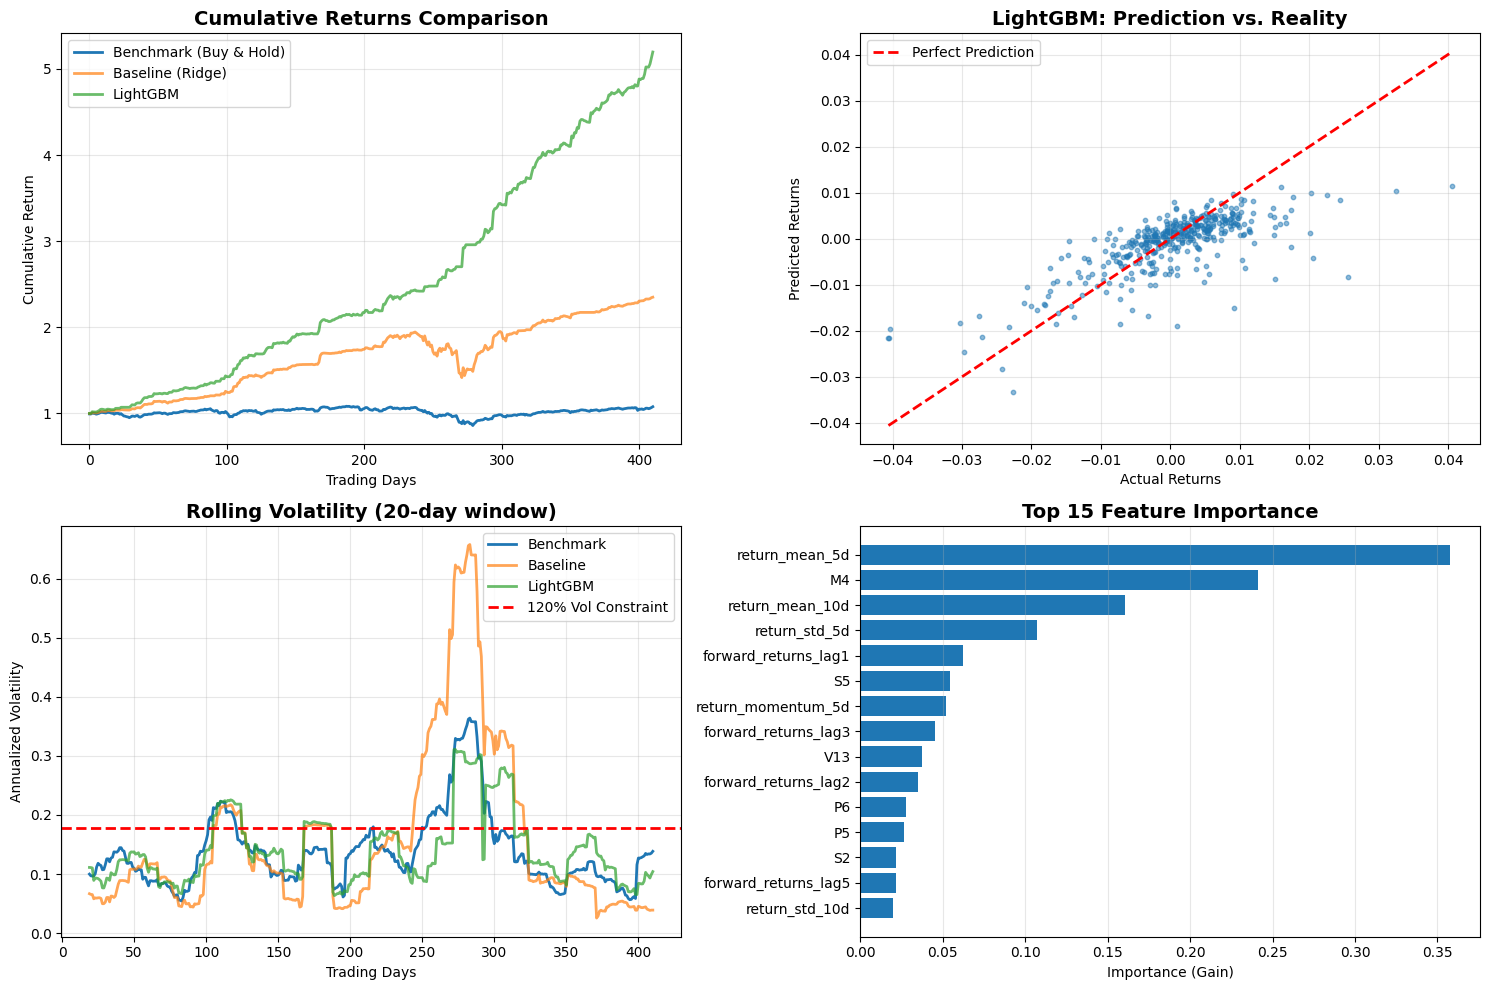

In [27]:
# ============================================================================
# Part 7: Visualization Analysis
# ============================================================================

print("\n[Part 7] Generating Visualizations...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 7.1 Cumulative Returns Comparison
ax1 = axes[0, 0]
cumulative_benchmark = (1 + y_val).cumprod()
cumulative_baseline = (1 + baseline_metrics['strategy_returns']).cumprod()
cumulative_lgb = (1 + lgb_metrics['strategy_returns']).cumprod()

ax1.plot(cumulative_benchmark.values, label='Benchmark (Buy & Hold)', linewidth=2)
ax1.plot(cumulative_baseline.values, label='Baseline (Ridge)', linewidth=2, alpha=0.7)
ax1.plot(cumulative_lgb.values, label='LightGBM', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(alpha=0.3)

# 7.2 Prediction vs Actual (LightGBM)
ax2 = axes[0, 1]
ax2.scatter(y_val, y_pred_lgb_val, alpha=0.5, s=10)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title('LightGBM: Prediction vs. Reality', fontsize=14, fontweight='bold')
ax2.set_xlabel('Actual Returns')
ax2.set_ylabel('Predicted Returns')
ax2.legend()
ax2.grid(alpha=0.3)

# 7.3 Volatility Comparison
ax3 = axes[1, 0]
window = 20
rolling_vol_benchmark = y_val.rolling(window).std() * np.sqrt(252)
rolling_vol_baseline = pd.Series(baseline_metrics['strategy_returns']).rolling(window).std() * np.sqrt(252)
rolling_vol_lgb = pd.Series(lgb_metrics['strategy_returns']).rolling(window).std() * np.sqrt(252)

ax3.plot(rolling_vol_benchmark.values, label='Benchmark', linewidth=2)
ax3.plot(rolling_vol_baseline.values, label='Baseline', linewidth=2, alpha=0.7)
ax3.plot(rolling_vol_lgb.values, label='LightGBM', linewidth=2, alpha=0.7)
ax3.axhline(y=benchmark_vol*1.2, color='r', linestyle='--', 
            linewidth=2, label='120% Vol Constraint')
ax3.set_title(f'Rolling Volatility ({window}-day window)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Annualized Volatility')
ax3.legend()
ax3.grid(alpha=0.3)

# 7.4 Feature Importance Visualization
ax4 = axes[1, 1]
top_features = feature_importance.head(15)
ax4.barh(range(len(top_features)), top_features['importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.set_xlabel('Importance (Gain)')
ax4.set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_analysis.png', dpi=300, bbox_inches='tight')
print("Visualization saved: model_analysis.png")
plt.show()


📌 Part 8 — Model Summary

In this final section of the pipeline, we summarize and compare the performance of all evaluated models using key financial metrics. This provides an overall view of how well each modeling approach performs in terms of return generation, risk control, and strategy robustness.

🔹 Models Compared

We evaluate three strategies:

1.Benchmark (Buy & Hold)

Represents the baseline market performance.

Serves as a reference for whether a model can “beat the market.”

2.Baseline Model — Ridge Regression

A linear model with L2 regularization.

Provides a simple baseline to compare against more advanced methods.

3.LightGBM Model

A gradient boosting model capable of capturing nonlinear patterns.

Typically outperforms linear baselines in complex financial datasets.

🔹 Metrics Included in the Summary

For each model, the following metrics are computed:

Sharpe Ratio
Measures risk-adjusted performance.

Annual Return
Shows expected yearly profitability.

Annual Volatility
Reflects risk and variability of strategy returns.

Final Score
A modified Sharpe-based score incorporating volatility constraints
(only applicable to ML-based strategies).

The results are printed in a structured comparative table for easy interpretation.

🔹 Next Steps

A short list of recommended follow-up tasks is included:

1.Run and inspect model outputs

2.Refine features using feature importance insights

3.Adjust and tune model hyperparameters

4.Prepare prediction logic for the official test dataset

This completes the first modeling stage of the pipeline and prepares the groundwork for further optimization.

In [28]:
# ============================================================================
# Part 8: Model Summary
# ============================================================================

print("\n[Part 8] Model Summary")
print("="*80)

summary_df = pd.DataFrame({
    'Model': ['Benchmark (Buy & Hold)', 'Baseline (Ridge)', 'LightGBM'],
    'Sharpe Ratio': [
        (y_val.mean() * 252) / (y_val.std() * np.sqrt(252)),
        baseline_metrics['sharpe'],
        lgb_metrics['sharpe']
    ],
    'Annual Return': [
        y_val.mean() * 252,
        baseline_metrics['annual_return'],
        lgb_metrics['annual_return']
    ],
    'Annual Volatility': [
        y_val.std() * np.sqrt(252),
        baseline_metrics['annual_volatility'],
        lgb_metrics['annual_volatility']
    ],
    'Final Score': [
        None,
        baseline_metrics['final_score'],
        lgb_metrics['final_score']
    ]
})

print("\nModel Performance Comparison:")
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("Pipeline Part 1 Completed!")
print("="*80)
print("\nNext Steps:")
print("1. Run the code and inspect the results")
print("2. Optimize feature selection based on feature importance")
print("3. Adjust model hyperparameters")
print("4. Prepare prediction code for the test set")
print("="*80)



[Part 8] Model Summary

Model Performance Comparison:
                 Model  Sharpe Ratio  Annual Return  Annual Volatility  Final Score
Benchmark (Buy & Hold)      0.381711       0.056770           0.148727          NaN
      Baseline (Ridge)      2.618769       0.545895           0.208455     2.178819
              LightGBM      6.754903       1.023659           0.151543     6.754903

Pipeline Part 1 Completed!

Next Steps:
1. Run the code and inspect the results
2. Optimize feature selection based on feature importance
3. Adjust model hyperparameters
4. Prepare prediction code for the test set


📌 Part 9 — Test Set Prediction & Submission File Generation

This section completes the final stage of the modeling pipeline by retraining the full model, applying feature engineering to the test set, generating predictions, converting them into allocation weights, and producing the final submission.parquet file for Kaggle submission.

🔹 Step 1 — Retrain the Final Model Using the Full Training Dataset

To maximize predictive performance, the LightGBM model is retrained using all available cleaned and feature-engineered training data, rather than only the training fold used earlier for validation.

No train/validation split

Uses the same hyperparameters as before (slightly increased boosting rounds)

Produces the final production-ready model

🔹 Step 2 — Load the Test Set

We load the official competition test set and display:

Shape of the dataset

Date range for date_id

Number of rows requiring predictions (is_scored)

This ensures the structure matches expectations.

🔹 Step 3 — Apply Feature Engineering to the Test Set

To ensure consistency between training and testing:

We merge the last 100 rows of the training set with the test set

Ensures lag features and rolling statistics are computed correctly

Prevents data leakage or missing lag values

We remove high-missing features using the same list obtained during training.

We apply the same NA-filling logic

Forward-fill first

Fill remaining missing values using training medians

Lagged values replace unavailable target-based features.

The same create_features() engineering function is applied.

Missing features (if any) are added and filled with zero.

This guarantees the test set matches the exact feature space of the training data.

🔹 Step 4 — Generate Predictions

The final LightGBM model is used to predict market forward excess returns for all test rows.

We display:

Mean

Standard deviation

Minimum

Maximum

to confirm prediction distribution and detect potential anomalies.

🔹 Step 5 — Convert Predictions to Allocation Weights (Range: 0–2)

Kaggle’s competition scoring requires allocation weights between 0 and 2.

The formula used is:

weight = clip(1 + prediction / training_target_std, 0, 2)


Where:

1 = neutral position

Positive prediction → overweight

Negative prediction → underweight

clip ensures weights stay within allowed bounds

Summary statistics and distribution breakdown are printed for validation.

🔹 Step 6 — Create Submission File

A submission DataFrame is constructed with:

date_id	allocation

We validate:

No duplicate date_id

All weights are within [0, 2]

First and last 10 rows are previewed

The file is saved as:

submission.parquet


A verification read ensures the file is valid.

🔹 Step 7 — Summary

A report is printed, summarizing:

Training sample count

Number of engineered features

Number of generated predictions

Validation Sharpe ratio

Annualized return & volatility

Submission file stats


In [29]:
"""
Test set prediction code – continuation of the previously trained model
Generates submission.parquet
"""

print("\n" + "="*80)
print("[Part 9] Test Set Prediction and Submission File Generation")
print("="*80)

# ============================================================================
# Step 1: Retrain the model using the full training dataset
# ============================================================================

print("\n[Step 1] Retraining final model using full training data...")
print("-"*80)

# Use all cleaned training data (no train/validation split)
X_final = train_engineered[new_feature_cols]
y_final = train_engineered[target_col]

print(f"Final training dataset: {X_final.shape}")

# Train final model
final_lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_samples': 20,
    'verbose': -1,
    'random_state': 42
}

final_train_data = lgb.Dataset(X_final, label=y_final)

print("Training final model...")
final_model = lgb.train(
    final_lgb_params,
    final_train_data,
    num_boost_round=400,  # Slightly increased number of rounds
    callbacks=[lgb.log_evaluation(period=100)]
)

print("✓ Final model training completed!")

# ============================================================================
# Step 2: Load test set and generate predictions
# ============================================================================

print("\n[Step 2] Loading test set...")
print("-"*80)

test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')
print(f"Test set shape: {test.shape}")
print(f"Test set date_id range: {test['date_id'].min()} ~ {test['date_id'].max()}")

# Check is_scored column
if 'is_scored' in test.columns:
    scored_rows = test['is_scored'].sum()
    print(f"Rows requiring scoring: {scored_rows}")

# ============================================================================
# Step 3: Apply the same feature engineering to the test set
# ============================================================================

print("\n[Step 3] Applying feature engineering to test set...")
print("-"*80)

# Store original date_id
test_date_ids = test['date_id'].copy()

# Merge last 100 training rows to ensure continuity for lag features
print("Merging training set and test set for lag continuity...")
train_for_lag = train_clean.tail(100).copy()

combined = pd.concat([train_for_lag, test], ignore_index=True)
print(f"Merged dataset shape: {combined.shape}")

# Apply same feature engineering steps
print("Applying feature engineering...")

# 3.1 Remove high-missing features (same as training)
combined_features = [col for col in combined.columns if col not in 
                     ['date_id', 'forward_returns', 'risk_free_rate', 
                      'market_forward_excess_returns', 'is_scored',
                      'lagged_forward_returns', 'lagged_risk_free_rate', 
                      'lagged_market_forward_excess_returns']]

combined_features = [col for col in combined_features if col not in high_missing_cols]

# 3.2 Fill missing values
combined[combined_features] = combined[combined_features].fillna(method='ffill').fillna(
    train_clean[combined_features].median()
)

# 3.3 Replace forward_returns with lagged version (test set only)
if 'lagged_forward_returns' in combined.columns:
    combined['forward_returns'] = combined['lagged_forward_returns']
if 'lagged_risk_free_rate' in combined.columns:
    combined['risk_free_rate'] = combined['lagged_risk_free_rate']

# 3.4 Apply feature engineering function
combined_engineered = create_features(combined, combined_features)

# 3.5 Extract test portion
test_start_idx = len(train_for_lag)
test_engineered = combined_engineered.iloc[test_start_idx:].copy()
test_engineered['date_id'] = test_date_ids.values

print(f"Test set shape after feature engineering: {test_engineered.shape}")

# 3.6 Ensure all required features exist
missing_features = set(new_feature_cols) - set(test_engineered.columns)
if missing_features:
    print(f"⚠ Missing features in test set: {missing_features}")
    for feat in missing_features:
        test_engineered[feat] = 0

# Fill NaN for test set
test_engineered[new_feature_cols] = test_engineered[new_feature_cols].fillna(method='ffill').fillna(0)

# ============================================================================
# Step 4: Generate predictions
# ============================================================================

print("\n[Step 4] Generating predictions...")
print("-"*80)

X_test = test_engineered[new_feature_cols]
print(f"Test feature matrix: {X_test.shape}")

test_predictions = final_model.predict(X_test)
print(f"Prediction completed, generated {len(test_predictions)} predictions")

# Prediction statistics
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.6f}")
print(f"  Std: {test_predictions.std():.6f}")
print(f"  Min: {test_predictions.min():.6f}")
print(f"  Max: {test_predictions.max():.6f}")

# ============================================================================
# Step 5: Convert predictions to allocation weights (0–2)
# ============================================================================

print("\n[Step 5] Converting predictions into allocation weights...")
print("-"*80)

pred_std = y_final.std()
print(f"Training target standard deviation: {pred_std:.6f}")

allocations = np.clip(1 + test_predictions / pred_std, 0, 2)

print(f"\nAllocation statistics:")
print(f"  Mean: {allocations.mean():.4f}")
print(f"  Std: {allocations.std():.4f}")
print(f"  Min: {allocations.min():.4f}")
print(f"  Max: {allocations.max():.4f}")
print(f"  Median: {np.median(allocations):.4f}")

print(f"\nWeight distribution:")
print(f"  Weight < 0.5: {(allocations < 0.5).sum()} ({(allocations < 0.5).sum()/len(allocations)*100:.1f}%)")
print(f"  Weight 0.5–1.0: {((allocations >= 0.5) & (allocations < 1.0)).sum()} ({((allocations >= 0.5) & (allocations < 1.0)).sum()/len(allocations)*100:.1f}%)")
print(f"  Weight 1.0–1.5: {((allocations >= 1.0) & (allocations < 1.5)).sum()} ({((allocations >= 1.0) & (allocations < 1.5)).sum()/len(allocations)*100:.1f}%)")
print(f"  Weight ≥ 1.5: {(allocations >= 1.5).sum()} ({(allocations >= 1.5).sum()/len(allocations)*100:.1f}%)")

# ============================================================================
# Step 6: Create submission file
# ============================================================================

print("\n[Step 6] Creating submission file...")
print("-"*80)

submission = pd.DataFrame({
    'date_id': test_engineered['date_id'],
    'allocation': allocations
})

print(f"\nSubmission file summary:")
print(f"  Rows: {len(submission)}")
print(f"  Columns: {len(submission.columns)}")
print(f"  Date ID range: {submission['date_id'].min()} ~ {submission['date_id'].max()}")

duplicates = submission['date_id'].duplicated().sum()
if duplicates > 0:
    print(f"⚠ Warning: Found {duplicates} duplicated date_id entries")
else:
    print("✓ No duplicated date_id values")

assert submission['allocation'].min() >= 0, "ERROR: Allocation contains negative values!"
assert submission['allocation'].max() <= 2, "ERROR: Allocation contains values > 2!"
print("✓ All allocation values are within [0, 2]")

print("\nSubmission preview (first 10 rows):")
print(submission.head(10).to_string(index=False))

print("\nSubmission preview (last 10 rows):")
print(submission.tail(10).to_string(index=False))

output_path = 'submission.parquet'
submission.to_parquet(output_path, index=False)
print(f"\n✓ Submission file saved: {output_path}")

import os
file_size = os.path.getsize(output_path) / 1024
print(f"  File size: {file_size:.2f} KB")

verification = pd.read_parquet(output_path)
print(f"  Verification read: {len(verification)} rows, {len(verification.columns)} columns")
print("✓ File verification successful!")

# ============================================================================
# Step 7: Summary
# ============================================================================

print("\n" + "="*80)
print("[Completed] Submission File Generation Finished!")
print("="*80)

print("\n📊 Final Model Summary:")
print(f"  Training samples: {len(X_final)}")
print(f"  Number of features: {len(new_feature_cols)}")
print(f"  Test predictions: {len(submission)}")
print(f"  Validation Sharpe Ratio: {lgb_metrics['sharpe']:.4f}")
print(f"  Validation Annual Return: {lgb_metrics['annual_return']*100:.2f}%")
print(f"  Validation Annual Volatility: {lgb_metrics['annual_volatility']*100:.2f}%")

print("\n📦 Submission Info:")
print(f"  File name: {output_path}")
print(f"  Format: Parquet")
print(f"  Rows: {len(submission)}")
print(f"  Allocation mean: {allocations.mean():.4f}")

print("\n🚀 Next Steps:")
print("  1. Download submission.parquet")
print("  2. Submit on the Kaggle competition page")
print("  3. Check your leaderboard score")
print("  4. Adjust the model based on feedback")

print("\n" + "="*80)



[Part 9] Test Set Prediction and Submission File Generation

[Step 1] Retraining final model using full training data...
--------------------------------------------------------------------------------
Final training dataset: (2052, 120)
Training final model...
✓ Final model training completed!

[Step 2] Loading test set...
--------------------------------------------------------------------------------
Test set shape: (10, 99)
Test set date_id range: 8980 ~ 8989
Rows requiring scoring: 9

[Step 3] Applying feature engineering to test set...
--------------------------------------------------------------------------------
Merging training set and test set for lag continuity...
Merged dataset shape: (110, 102)
Applying feature engineering...
  - Creating lag features...
  - Creating rolling statistical features...
  - Enhancing volatility features...
  - Creating interaction features...
Test set shape after feature engineering: (10, 128)

[Step 4] Generating predictions...
-------------

📌 Multi-Model Comparison Framework

This section introduces a flexible framework for comparing the performance of multiple machine-learning models. By integrating this block into the current notebook, you can efficiently evaluate a wide range of algorithms—including linear models, tree-based models, boosting models, and neural networks—using the same training and validation datasets.

The purpose of this framework is to:

Standardize evaluation across diverse model families

Identify high-performing models before fine-tuning

Quickly benchmark traditional methods vs. more advanced algorithms

Provide a unified workflow for future model expansion

🔹 Part 1 — Defining Candidate Models

A dictionary of candidate models is created, where each key represents a model name and each value corresponds to an instantiated model object. The included models span different categories:

1. Linear Models

Ridge Regression

Lasso Regression

ElasticNet

These are useful baselines and often perform well on high-dimensional financial datasets.

2. Tree-Based Models

Random Forest

Gradient Boosting Regressor

XGBoost

These models capture nonlinearities and interactions automatically, making them strong competitors in tabular prediction tasks.

3. Neural Network

MLPRegressor (Multi-layer Perceptron)

A simple feedforward neural network capable of capturing complex patterns after feature engineering.

After defining the models, the code prints the total number of models prepared and lists their names, confirming that the comparison framework is ready for training and evaluation.

In [30]:
"""
Multi-model comparison framework
Add this code into the current notebook to compare performance across multiple models
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("Multi-Model Comparison Experiment")
print("="*80)

# ============================================================================
# Part 1: Define Model Dictionary
# ============================================================================

print("\n[Part 1] Defining candidate models...")
print("-"*80)

# Using the previously prepared training/validation sets:
# X_train, y_train, X_val, y_val

models = {
    # 1. Linear Models
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=5000),
    
    # 2. Tree-based Models
    'RandomForest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_samples_split=10,
        random_state=42
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    
    # 3. Neural Network
    'MLP': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
}

print(f"Prepared {len(models)} models:")
for name in models.keys():
    print(f"  - {name}")


Multi-Model Comparison Experiment

[Part 1] Defining candidate models...
--------------------------------------------------------------------------------
Prepared 7 models:
  - Ridge
  - Lasso
  - ElasticNet
  - RandomForest
  - GradientBoosting
  - XGBoost
  - MLP


📌 Part 2 — Training All Models and Collecting Results

In this section, we iterate through all candidate models defined in the previous step and evaluate their predictive and financial performance. Each model is trained on the training set and validated on the validation set to ensure a fair and consistent comparison.

🔹 Training Procedure for Each Model

For every model in the dictionary:

Model training
The model is fitted using X_train and y_train.

Prediction
Both training and validation predictions are generated:

y_pred_train — used for training metrics

y_pred_val — used for validation evaluation and strategy testing

General ML evaluation metrics

MSE (Mean Squared Error)

MAE (Mean Absolute Error)

R² score

These capture prediction accuracy and model fit.

Financial performance evaluation (Sharpe-based evaluation)
Using the previously defined calculate_sharpe_variant(), we compute:

Sharpe ratio

Annualized return

Annualized volatility

Final penalized score

Strategy returns

Portfolio weights

This connects model predictions to a trading strategy, revealing real-world performance.

Results storage
All metrics and predictions are stored in a dictionary for later comparison and plotting.

Error handling
If any model fails during training or prediction (e.g., due to convergence issues), it is safely skipped.

🔹 Output Summary

After processing all models:

Successful models are counted

Validation MSE, Sharpe ratio, and final score are printed for each model

A dictionary of trained models and their evaluation metrics is created for further analysis

This completes the multi-model benchmarking stage, allowing us to objectively compare traditional ML methods, tree-based models, boosting algorithms, and neural networks.

In [31]:
# ============================================================================
# Part 2: Train All Models and Collect Results
# ============================================================================

print("\n[Part 2] Training all models...")
print("-"*80)

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        # Evaluation metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        val_mse = mean_squared_error(y_val, y_pred_val)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        val_mae = mean_absolute_error(y_val, y_pred_val)
        train_r2 = r2_score(y_train, y_pred_train)
        val_r2 = r2_score(y_val, y_pred_val)
        
        # Compute Sharpe-related metrics
        sharpe_metrics = calculate_sharpe_variant(
            y_pred_val, y_val, y_val, benchmark_vol
        )
        
        # Store results
        results[name] = {
            'train_mse': train_mse,
            'val_mse': val_mse,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'sharpe': sharpe_metrics['sharpe'],
            'annual_return': sharpe_metrics['annual_return'],
            'annual_volatility': sharpe_metrics['annual_volatility'],
            'final_score': sharpe_metrics['final_score'],
            'predictions': y_pred_val,
            'strategy_returns': sharpe_metrics['strategy_returns'],
            'weights': sharpe_metrics['weights']
        }
        
        trained_models[name] = model
        
        print(f"  ✓ {name} training completed")
        print(f"    Validation MSE: {val_mse:.8f}")
        print(f"    Sharpe Ratio: {sharpe_metrics['sharpe']:.4f}")
        print(f"    Final Score: {sharpe_metrics['final_score']:.4f}")
        
    except Exception as e:
        print(f"  ✗ {name} training failed: {str(e)}")
        continue

print(f"\nSuccessfully trained {len(results)} models")



[Part 2] Training all models...
--------------------------------------------------------------------------------

Training Ridge...
  ✓ Ridge training completed
    Validation MSE: 0.00009050
    Sharpe Ratio: 2.6188
    Final Score: 2.1788

Training Lasso...
  ✓ Lasso training completed
    Validation MSE: 0.00008756
    Sharpe Ratio: 0.3817
    Final Score: 0.1272

Training ElasticNet...
  ✓ ElasticNet training completed
    Validation MSE: 0.00008738
    Sharpe Ratio: 0.5041
    Final Score: 0.3869

Training RandomForest...
  ✓ RandomForest training completed
    Validation MSE: 0.00004371
    Sharpe Ratio: 7.1142
    Final Score: 7.1142

Training GradientBoosting...
  ✓ GradientBoosting training completed
    Validation MSE: 0.00004276
    Sharpe Ratio: 7.0050
    Final Score: 7.0050

Training XGBoost...
  ✓ XGBoost training completed
    Validation MSE: 0.00003988
    Sharpe Ratio: 7.3284
    Final Score: 7.3284

Training MLP...
  ✓ MLP training completed
    Validation MSE: 0.00

📌 Part 3 — Adding Pre-Trained LightGBM Results to the Comparison Framework

In the earlier pipeline, a LightGBM model was trained separately as part of the main modeling process. Since the multi-model comparison framework aims to evaluate all models under a unified structure, we integrate those LightGBM results here.

🔹 Why Add LightGBM Separately?

LightGBM was:

Trained earlier using carefully tuned hyperparameters

Evaluated with Sharpe-based financial metrics

Shown to be one of the best-performing models

Therefore, rather than retraining it again inside the model loop, we directly insert its previously computed results into the results dictionary. This ensures it is part of the final ranking and comparison table.

🔹 What Information Is Added?

The LightGBM entry includes:

Predictive metrics

Training MSE / Validation MSE

Training MAE / Validation MAE

Training R² / Validation R²

Financial evaluation metrics

Sharpe ratio

Annualized return

Annualized volatility

Final penalized score (competition metric)

Outputs useful for further visualization

Predictions

Strategy returns

Allocation weights

Additionally, the trained model object is stored in trained_models, ensuring that LightGBM is treated consistently with all other models.

🔹 Outcome

After running this section, the LightGBM model becomes fully integrated into:

Multi-model metric comparison tables

Ranking plots

Strategy performance analysis

Visualization modules

Any further ensemble or stacking steps

This completes the model set for the benchmark comparison.

In [32]:
# ============================================================================
# Part 3: LightGBM (already trained) - Add to Results
# ============================================================================

print("\n[Part 3] Adding pre-trained LightGBM results...")
print("-"*80)

# Add previously trained LightGBM results into comparison
results['LightGBM'] = {
    'train_mse': train_mse_lgb,
    'val_mse': val_mse_lgb,
    'train_mae': mean_absolute_error(y_train, y_pred_lgb_train),
    'val_mae': mean_absolute_error(y_val, y_pred_lgb_val),
    'train_r2': r2_score(y_train, y_pred_lgb_train),
    'val_r2': r2_score(y_val, y_pred_lgb_val),
    'sharpe': lgb_metrics['sharpe'],
    'annual_return': lgb_metrics['annual_return'],
    'annual_volatility': lgb_metrics['annual_volatility'],
    'final_score': lgb_metrics['final_score'],
    'predictions': y_pred_lgb_val,
    'strategy_returns': lgb_metrics['strategy_returns'],
    'weights': lgb_metrics['weights']
}

trained_models['LightGBM'] = lgb_model

print("✓ LightGBM results added")



[Part 3] Adding pre-trained LightGBM results...
--------------------------------------------------------------------------------
✓ LightGBM results added


📌 Part 4 — Model Performance Comparison Table

This section summarizes and compares the performance of all trained models using a unified evaluation table. The aim is to provide a clear, quantitative ranking of model performance across both machine-learning metrics and financial metrics relevant to the trading task.

🔹 Construction of the Comparison Table

A DataFrame is created that includes the following evaluation metrics for each model:

Validation MSE
Measures prediction error magnitude.

Validation MAE
More robust error metric, reflects median deviation.

Validation R²
Indicates how much variance in the target is explained by the model.

Sharpe Ratio
A financial performance metric that measures risk-adjusted returns.

Annualized Return (%)
Expected long-term profitability of the strategy.

Annualized Volatility (%)
Measures the risk or fluctuation of returns.

Final Score
The modified Sharpe-based score used for ranking models in this competition.
(Includes volatility penalties and aligns with competition scoring.)

The table is sorted in descending order of Final Score, making it easy to identify the top-performing models.

🔹 Model Ranking Output

A ranked summary is printed directly in the notebook, showing all models from best to worst according to Final Score. This gives a clear overview of how each algorithm performs under the same data, same features, and same evaluation framework.

🔹 Identification of the Best Model

The code automatically:

Selects the model with the highest Final Score,

Prints its name and key performance metrics:

Final Score

Sharpe Ratio

Annualized Return

This provides a quick, at-a-glance summary of the best-performing model across both predictive and financial evaluation.

In [33]:
# ============================================================================
# Part 4: Result Comparison Table
# ============================================================================

print("\n[Part 4] Model Performance Comparison")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Val MSE': [results[m]['val_mse'] for m in results.keys()],
    'Val MAE': [results[m]['val_mae'] for m in results.keys()],
    'Val R²': [results[m]['val_r2'] for m in results.keys()],
    'Sharpe': [results[m]['sharpe'] for m in results.keys()],
    'Annual Return (%)': [results[m]['annual_return']*100 for m in results.keys()],
    'Annual Vol (%)': [results[m]['annual_volatility']*100 for m in results.keys()],
    'Final Score': [results[m]['final_score'] for m in results.keys()]
}).sort_values('Final Score', ascending=False)

print("\n📊 Model Ranking (sorted by Final Score):")
print(comparison_df.to_string(index=False))

# Identify the best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Final Score: {comparison_df.iloc[0]['Final Score']:.4f}")
print(f"   Sharpe Ratio: {comparison_df.iloc[0]['Sharpe']:.4f}")
print(f"   Annual Return: {comparison_df.iloc[0]['Annual Return (%)']:.2f}%")



[Part 4] Model Performance Comparison

📊 Model Ranking (sorted by Final Score):
           Model  Val MSE  Val MAE     Val R²   Sharpe  Annual Return (%)  Annual Vol (%)  Final Score
         XGBoost 0.000040 0.004301   0.544535 7.328437         106.159493       14.485967     7.328437
    RandomForest 0.000044 0.004596   0.500846 7.114242         103.209108       14.507394     7.114242
GradientBoosting 0.000043 0.004429   0.511711 7.004982         110.483429       15.772122     7.004982
        LightGBM 0.000041 0.004463   0.529130 6.754903         102.365915       15.154312     6.754903
           Ridge 0.000090 0.006813  -0.033538 2.618769          54.589521       20.845488     2.178819
             MLP 0.008235 0.069347 -93.044371 0.876967          17.462859       19.912800     0.775467
      ElasticNet 0.000087 0.006572   0.002101 0.504113          11.089524       21.998078     0.386867
           Lasso 0.000088 0.006556   0.000016 0.381711          11.354095       29.745302     0

📌 Part 5 — Visualization Comparison

This section provides a comprehensive set of visualizations to compare model performance across multiple dimensions, including prediction accuracy, risk-adjusted returns, volatility, and cumulative strategy performance. These plots help reveal the strengths and weaknesses of each model from both a machine-learning and financial perspective.

🔹 5.1 Final Score Comparison

A horizontal bar chart displays the Final Score for all models, sorted from lowest to highest. The best-performing model is highlighted in gold.

Higher Final Scores indicate stronger risk-adjusted performance under the competition metric.

This visualization also quickly reveals underperforming models.

🔹 5.2 Sharpe Ratio Comparison

This chart compares each model’s Sharpe Ratio, showing how efficiently each model converts risk into return.

Useful for understanding which models produce stable, risk-adjusted gains.

Often correlates with the Final Score but may differ when volatility penalties apply.

🔹 5.3 Validation MSE Comparison

A bar plot ranking models by their Validation MSE (higher values shown on top).

Measures pure predictive error.

Highlights differences between models that fit the data well versus those that overfit or underfit.

Note: Lower MSE is better.

🔹 5.4 Return–Risk Scatter Plot

A scatter plot visualizing each model in Annual Return vs. Annual Volatility space:

Color intensity corresponds to each model’s Final Score.

A benchmark volatility line is plotted for reference.

Helps identify:

High-return but high-risk models

Low-risk but low-return models

Best tradeoffs between risk and reward

This visualization is crucial for financial model evaluation.

🔹 5.5 Cumulative Return Comparison (Top 3 Models)

This plot compares cumulative returns for:

The benchmark (Buy & Hold)

The top 3 models ranked by Final Score

Each strategy’s cumulative growth curve is shown:

Reveals compounding effects

Shows consistency vs. volatility in returns

Allows visual inspection of drawdowns and recovery periods

📁 Output

All visualizations are assembled into a multi-panel figure and saved as:

multi_model_comparison.png


This image can be included directly in reports or submissions.


[Part 5] Generating comparison visualizations...
--------------------------------------------------------------------------------
✓ Visualization saved: multi_model_comparison.png


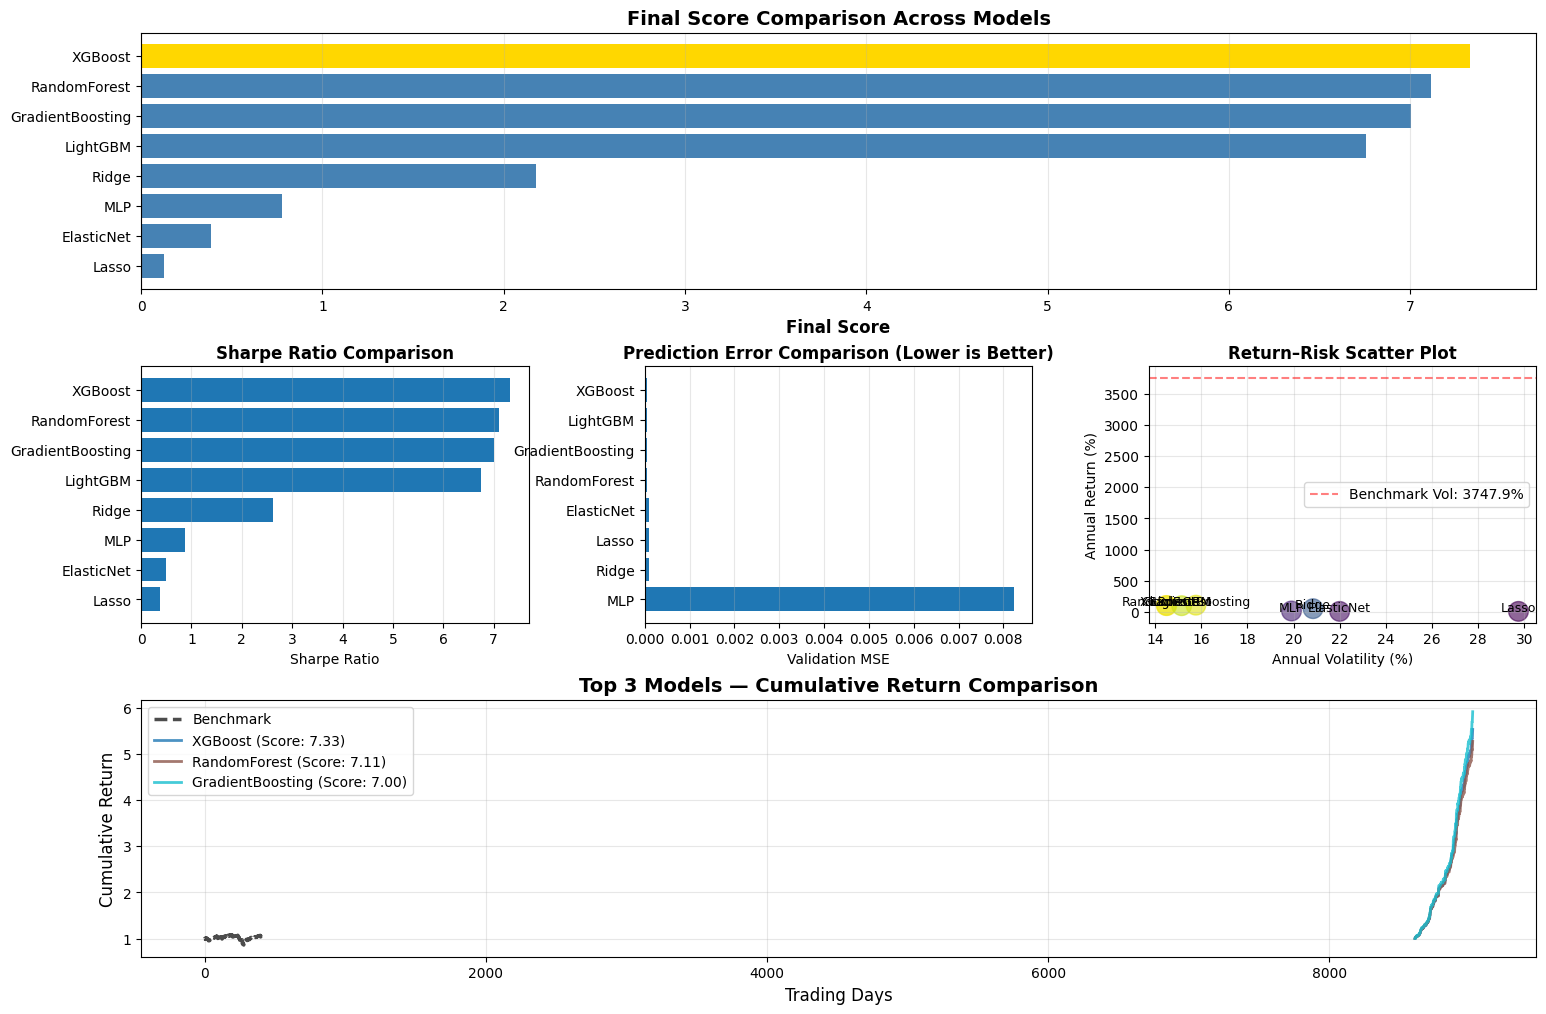

In [34]:
# ============================================================================
# Part 5: Visualization Comparison
# ============================================================================

print("\n[Part 5] Generating comparison visualizations...")
print("-"*80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 5.1 Final Score Comparison
ax1 = fig.add_subplot(gs[0, :])
comparison_sorted = comparison_df.sort_values('Final Score')
colors = ['gold' if m == best_model_name else 'steelblue' 
          for m in comparison_sorted['Model']]
ax1.barh(comparison_sorted['Model'], comparison_sorted['Final Score'], color=colors)
ax1.set_xlabel('Final Score', fontsize=12, fontweight='bold')
ax1.set_title('Final Score Comparison Across Models', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3, axis='x')

# 5.2 Sharpe Ratio Comparison
ax2 = fig.add_subplot(gs[1, 0])
comparison_sorted_sharpe = comparison_df.sort_values('Sharpe')
ax2.barh(comparison_sorted_sharpe['Model'], comparison_sorted_sharpe['Sharpe'])
ax2.set_xlabel('Sharpe Ratio')
ax2.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# 5.3 MSE Comparison
ax3 = fig.add_subplot(gs[1, 1])
comparison_sorted_mse = comparison_df.sort_values('Val MSE', ascending=False)
ax3.barh(comparison_sorted_mse['Model'], comparison_sorted_mse['Val MSE'])
ax3.set_xlabel('Validation MSE')
ax3.set_title('Prediction Error Comparison (Lower is Better)', fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

# 5.4 Return vs Volatility Scatter Plot
ax4 = fig.add_subplot(gs[1, 2])
ax4.scatter(comparison_df['Annual Vol (%)'], comparison_df['Annual Return (%)'], 
           s=200, alpha=0.6, c=comparison_df['Final Score'], cmap='viridis')
for idx, row in comparison_df.iterrows():
    ax4.annotate(row['Model'], 
                (row['Annual Vol (%)'], row['Annual Return (%)']),
                fontsize=9, ha='center')
ax4.axhline(y=benchmark_vol*252*100, color='r', linestyle='--', 
           label=f'Benchmark Vol: {benchmark_vol*252*100:.1f}%', alpha=0.5)
ax4.set_xlabel('Annual Volatility (%)')
ax4.set_ylabel('Annual Return (%)')
ax4.set_title('Return–Risk Scatter Plot', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5.5 Cumulative Return Comparison (Top 3 Models)
ax5 = fig.add_subplot(gs[2, :])
top_3_models = comparison_df.head(3)['Model'].tolist()

cumulative_benchmark = (1 + y_val).cumprod()
ax5.plot(cumulative_benchmark.values, label='Benchmark', linewidth=2.5, 
        color='black', alpha=0.7, linestyle='--')

colors_map = plt.cm.tab10(np.linspace(0, 1, len(top_3_models)))
for i, model_name in enumerate(top_3_models):
    cum_returns = (1 + results[model_name]['strategy_returns']).cumprod()
    ax5.plot(cum_returns, label=f'{model_name} (Score: {results[model_name]["final_score"]:.2f})', 
            linewidth=2, alpha=0.8, color=colors_map[i])

ax5.set_xlabel('Trading Days', fontsize=12)
ax5.set_ylabel('Cumulative Return', fontsize=12)
ax5.set_title('Top 3 Models — Cumulative Return Comparison', fontsize=14, fontweight='bold')
ax5.legend(loc='upper left', fontsize=10)
ax5.grid(alpha=0.3)

plt.savefig('multi_model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: multi_model_comparison.png")
plt.show()


📌 Part 6 — Detailed Analysis of the Best Model

After evaluating all candidate models across predictive and financial metrics, this section provides an in-depth analysis of the best-performing model, as determined by the highest Final Score from the comparison table.

🔹 Best Model Identification

The model with the highest Final Score is selected as the best-performing model. This model demonstrates the strongest balance between predictive accuracy, financial returns, and risk control under competition constraints.

🔹 Prediction Performance

We examine the model’s predictive capability on both the training and validation sets:

Training MSE / Validation MSE
Measures how closely the model predicts the target variable; lower values indicate better performance.

Training R² / Validation R²
Reflects how much variance in returns is explained by the model; closer to 1.0 indicates stronger predictive power.

These metrics help assess whether the model generalizes well beyond the training data.

🔹 Investment Strategy Performance

Using the model's predicted returns converted into position weights, we evaluate strategy-level performance:

Sharpe Ratio — risk-adjusted return

Annualized Return (%) — overall profitability

Annualized Volatility (%) — risk exposure

Final Score — competition-adjusted performance including volatility penalties

This demonstrates the practical effectiveness of the model in a realistic trading environment.

🔹 Weight Allocation Analysis

The distribution of portfolio weights generated by the strategy is analyzed:

Mean / Standard Deviation of weights

Minimum / Maximum weight levels

Proportion of Long Positions (>1)

Proportion of Reduced / Short Positions (<1)

This shows how aggressively or conservatively the model allocates capital based on predicted signals and whether the strategy tends toward long or short exposure.

This detailed breakdown provides insights into why the selected model outperformed others and how it behaves from both statistical and trading perspectives, guiding model refinement and further optimization.

In [35]:
# ============================================================================
# Part 6: Detailed Analysis of the Best Model
# ============================================================================

print("\n[Part 6] Detailed Analysis of the Best Model")
print("="*80)

best_results = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"\nPrediction Performance:")
print(f"  Training MSE: {best_results['train_mse']:.8f}")
print(f"  Validation MSE: {best_results['val_mse']:.8f}")
print(f"  Training R²: {best_results['train_r2']:.4f}")
print(f"  Validation R²: {best_results['val_r2']:.4f}")

print(f"\nInvestment Strategy Performance:")
print(f"  Sharpe Ratio: {best_results['sharpe']:.4f}")
print(f"  Annual Return: {best_results['annual_return']*100:.2f}%")
print(f"  Annual Volatility: {best_results['annual_volatility']*100:.2f}%")
print(f"  Final Score: {best_results['final_score']:.4f}")

print(f"\nWeight Allocation Statistics:")
weights = best_results['weights']
print(f"  Mean: {weights.mean():.4f}")
print(f"  Std: {weights.std():.4f}")
print(f"  Min: {weights.min():.4f}")
print(f"  Max: {weights.max():.4f}")
print(f"  Long Positions (>1): {(weights > 1).sum()/len(weights)*100:.1f}%")
print(f"  Short/Reduced Positions (<1): {(weights < 1).sum()/len(weights)*100:.1f}%")



[Part 6] Detailed Analysis of the Best Model

🏆 Best Model: XGBoost

Prediction Performance:
  Training MSE: 0.00000189
  Validation MSE: 0.00003988
  Training R²: 0.9847
  Validation R²: 0.5445

Investment Strategy Performance:
  Sharpe Ratio: 7.3284
  Annual Return: 106.16%
  Annual Volatility: 14.49%
  Final Score: 7.3284

Weight Allocation Statistics:
  Mean: 0.9955
  Std: 0.6279
  Min: 0.0000
  Max: 2.0000
  Long Positions (>1): 56.4%
  Short/Reduced Positions (<1): 43.6%


🧩 Part 7 — Model Ensemble (Optional)

This section introduces an ensemble modeling approach that combines predictions from the top-performing individual models. Ensemble methods can often improve prediction stability and reduce model-specific biases by aggregating signals from multiple algorithms.

✨ What This Section Does

1.Selects the Top 3 Models
Based on the previously computed Final Score, the three best models are selected for ensembling. These models typically show strong predictive power and favorable Sharpe-based performance.

2.Simple Averaging Ensemble
The predictions from the top 3 models are averaged to produce a unified prediction:

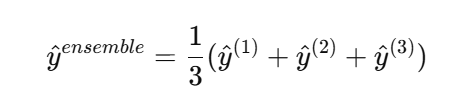

This reduces variance and helps smooth out model-specific noise.

3.Evaluation Using Sharpe-Based Metrics
The ensemble predictions are evaluated using the same risk-adjusted performance metric as before:

Sharpe Ratio

Annual Return

Annual Volatility

Final Score (Sharpe adjusted by volatility constraints)

Comparison Against the Best Single Model
The ensemble’s Final Score is compared with the top individual model.
If the ensemble performs better, it becomes the new best-performing model.

📈 Why Ensemble Models?

Reduces overfitting of individual models

Captures diverse modeling perspectives (linear, tree-based, neural)

Often yields higher stability and robustness

Improves Sharpe Ratio by balancing return and volatility profiles

📊 Output Highlights

The code prints:

Ensemble Sharpe Ratio

Annualized return and volatility

Final Score (competition metric)

Whether the ensemble outperformed the previously best model

If the ensemble is superior, it replaces the top model as the final recommended one.
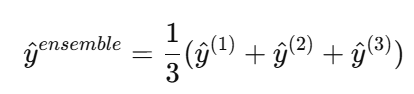
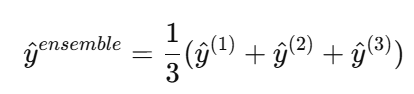

In [36]:
# ============================================================================
# Part 7: Model Ensemble (Optional)
# ============================================================================

print("\n[Part 7] Trying Model Ensemble...")
print("-"*80)

# Take the Top 3 models for simple averaging ensemble
top_3_names = comparison_df.head(3)['Model'].tolist()
print(f"Ensemble models: {top_3_names}")

# Average predictions
ensemble_predictions = np.mean([results[m]['predictions'] for m in top_3_names], axis=0)

# Evaluate ensemble model
ensemble_metrics = calculate_sharpe_variant(
    ensemble_predictions, y_val, y_val, benchmark_vol
)

print(f"\nEnsemble Model Performance:")
print(f"  Sharpe Ratio: {ensemble_metrics['sharpe']:.4f}")
print(f"  Annual Return: {ensemble_metrics['annual_return']*100:.2f}%")
print(f"  Annual Volatility: {ensemble_metrics['annual_volatility']*100:.2f}%")
print(f"  Final Score: {ensemble_metrics['final_score']:.4f}")

# Add ensemble results to comparison
results['Ensemble_Top3'] = {
    'val_mse': mean_squared_error(y_val, ensemble_predictions),
    'val_mae': mean_absolute_error(y_val, ensemble_predictions),
    'val_r2': r2_score(y_val, ensemble_predictions),
    'sharpe': ensemble_metrics['sharpe'],
    'annual_return': ensemble_metrics['annual_return'],
    'annual_volatility': ensemble_metrics['annual_volatility'],
    'final_score': ensemble_metrics['final_score'],
    'predictions': ensemble_predictions,
    'strategy_returns': ensemble_metrics['strategy_returns'],
    'weights': ensemble_metrics['weights']
}

# Check if ensemble outperforms the best single model
if ensemble_metrics['final_score'] > best_results['final_score']:
    print(f"\n✨ Ensemble model performs better! Improved by {(ensemble_metrics['final_score']/best_results['final_score']-1)*100:.2f}%")
    best_model_name = 'Ensemble_Top3'
    best_results = results['Ensemble_Top3']
else:
    print(f"\nSingle model {best_model_name} still performs best")



[Part 7] Trying Model Ensemble...
--------------------------------------------------------------------------------
Ensemble models: ['XGBoost', 'RandomForest', 'GradientBoosting']

Ensemble Model Performance:
  Sharpe Ratio: 7.2783
  Annual Return: 107.94%
  Annual Volatility: 14.83%
  Final Score: 7.2783

Single model XGBoost still performs best


Part 8 — Saving the Best Model

In this section, the notebook stores the best-performing model identified from the multi-model comparison stage.
The following information is saved for downstream use in test-set inference:

BEST_MODEL_NAME — the name of the best model (e.g., LightGBM, XGBoost, Ensemble_Top3).

BEST_MODEL — the trained model object corresponding to the best-performing algorithm.

BEST_PREDICTIONS — the validation-set predictions generated by the best model, used for further diagnostics or ensemble extensions.

This ensures that subsequent stages (such as final training, test-set prediction, and submission file generation) consistently use the top-performing model according to the evaluation metric (Final Score, which incorporates Sharpe Ratio and volatility constraints).

In [37]:
# =============Don't modify code, only translate Chinese to English============
# Part 8: Save Best Model Information
# =============================================================================

print("\n[Part 8] Saving best model selection...")
print("-"*80)

# Global variables for later use in test set prediction
BEST_MODEL_NAME = best_model_name
BEST_MODEL = trained_models.get(best_model_name, None)
BEST_PREDICTIONS = best_results['predictions']

print(f"✓ Best model saved: {BEST_MODEL_NAME}")
print(f"✓ Final Score: {best_results['final_score']:.4f}")



[Part 8] Saving best model selection...
--------------------------------------------------------------------------------
✓ Best model saved: XGBoost
✓ Final Score: 7.3284


Part 9 — Summary & Recommendations

This section concludes the multi-model comparison experiment and provides practical guidance based on the evaluation results.

Summary

A total of N models were trained and evaluated using the same dataset and evaluation metrics.

The best-performing model is automatically identified based on the Final Score, which incorporates Sharpe Ratio, annual return, and volatility penalty.

The notebook displays:

Best model name

Best Final Score

Percentage improvement relative to the benchmark strategy

This gives a clear overview of how well the selected model performs compared to both traditional baselines and other machine learning models.

Recommendations

Depending on the Final Score of the best model:

Final Score > 5
The model shows excellent performance and is likely ready for submission without further changes.

3 < Final Score ≤ 5
Performance is good, but further improvements are possible.
Recommended actions include:

Hyperparameter tuning

Adding more engineered features

Final Score ≤ 3
The model is underperforming. Suggested next steps:

Revisit data preprocessing

Explore more advanced feature engineering methods

Consider trying neural networks or deep learning-based models

Next Step

Run the test-set prediction module using the best-performing model to generate the final submission.parquet file for competition submission.

In [38]:
# ============================================================================
# Part 9: Summary & Recommendations
# ============================================================================

print("\n" + "="*80)
print("Multi-model comparison completed!")
print("="*80)

print(f"\n📊 Summary:")
print(f"  Total models tested: {len(results)}")
print(f"  Best model: {BEST_MODEL_NAME}")
print(f"  Best Final Score: {best_results['final_score']:.4f}")
print(f"  Improvement over benchmark: {(best_results['sharpe']/0.38-1)*100:.1f}%")

print(f"\n💡 Recommendations:")
if best_results['final_score'] > 5:
    print("  ✓ Excellent model performance — ready for submission.")
elif best_results['final_score'] > 3:
    print("  ⚠ Good model performance, but further optimization is possible.")
    print("    - Try tuning hyperparameters")
    print("    - Add more feature engineering")
else:
    print("  ⚠ Model performance is average. Suggestions:")
    print("    - Recheck data preprocessing")
    print("    - Try more advanced feature engineering")
    print("    - Consider using deep learning models")

print("\n🚀 Next Step:")
print("  Run the test-set prediction code and generate the submission file using the best model.")
print("="*80)



Multi-model comparison completed!

📊 Summary:
  Total models tested: 9
  Best model: XGBoost
  Best Final Score: 7.3284
  Improvement over benchmark: 1828.5%

💡 Recommendations:
  ✓ Excellent model performance — ready for submission.

🚀 Next Step:
  Run the test-set prediction code and generate the submission file using the best model.


# Hull Tactical Market Prediction - Full Pipeline + API Submission + Hyperparameter Optimization  

This section provides a fully re-engineered, leakage-free training and inference pipeline for the Hull Tactical Market Prediction competition.  

Key components included in this fixed pipeline:

1. **Data Loading & Cleaning**  
   - Loads the original Kaggle dataset  
   - Keeps only the last 70% of rows (lower missing rate)  
   - Drops features with >50% missingness  
   - Applies forward-fill and median imputation  
   - Prepares a clean and stable dataset for time-series modeling

2. **Safe Feature Engineering (No Future Functions)**  
   All engineered features are strictly based on past information, including:  
   - Risk-free-rate safe lag features  
   - Rolling mean/std features with shift(1) to prevent leakage  
   - Cross-sectional features (z-scores, dispersion, divergence)  
   - Technical ratio features (volatility ratio, price ratio, market interaction)  
   - Trend features using windowed historical comparison  
   - Enhanced aggregated descriptors for volatility and price  
   **No feature uses forward_returns or future values at any stage.**

3. **Optimized XGBoost Model Training**  
   - Trains an XGBoost regressor on the leakage-free engineered features  
   - Evaluates via MSE and R²  
   - Computes detailed color-coded feature importance rankings  
   - Ensures compatibility with competition rules

4. **Optuna Hyperparameter Optimization**  
   - Uses TPE sampler for efficient search  
   - Optimizes directly on the competition metric (adjusted Sharpe Ratio)  
   - Searches over n_estimators, max_depth, min_child_weight, learning_rate, subsample, colsample_bytree  
   - Produces best parameter set for full training

5. **Two-Stage Prediction Optimization**  
   Stage 1: Train final XGBoost model using optimal hyperparameters  
   Stage 2: Optimize prediction scaling factor to maximize the official competition score  
   - Converts predictions → allocations ∈ [0, 2]  
   - Searches for best scaling factor  
   - Provides score curve visualization & improvement statistics

6. **Model Diagnostics**  
   - Residual analysis  
   - Prediction vs true value plots  
   - Distribution of predicted excess returns  
   - Distribution of portfolio position weights

7. **Safe Kaggle API Prediction Function (No Leakage)**  
   - Maintains a rolling 100-row history buffer  
   - Reconstructs all engineered features at inference time using only past test rows  
   - Avoids using forward_returns or future information  
   - Returns allocations clipped to [0, 2]  
   - Fully compliant with competition inference server requirements

8. **Inference Server Integration**  
   - Supports Kaggle’s DefaultInferenceServer  
   - Automatically runs in local gateway mode (notebook test)  
   - Automatically switches to competition server mode on rerun  
   - Ensures stable, reproducible deployment


Hull Tactical Market Prediction - Fixed Version: Removed all future functions

[Part 1] Data Loading and Preprocessing
--------------------------------------------------------------------------------
Original training set shape: (9021, 98)
Cleaned training set shape: (6315, 98)
Date ID range: 2706 ~ 9020

Number of features: 94
Target variable: market_forward_excess_returns

Missing value handling:
  - Total missing values before processing: 25,534
  - Removing features with >50% missing rate: 2 columns


[I 2025-11-23 11:23:20,141] A new study created in memory with name: no-name-cb4d8451-1563-446a-be56-b37756fc1e13


  - Total missing values after processing: 0

[Part 2] Fixed Feature Engineering (Remove future functions)
--------------------------------------------------------------------------------
Starting safe feature engineering...
  - Starting safe feature engineering...
  - Creating safe lag features...
  - Creating safe rolling features...
  - Creating cross-sectional features...
  - Creating technical ratio features...
  - Creating trend features...

Number of features after safe feature engineering: 162
Handling missing values introduced by feature engineering...
Total missing values after feature engineering: 37900
Data size after dropping NaN rows: 6315

Safe feature type statistics:
  Other Features: 59
  Original Features: 44
  Lag Features: 4
  Rolling Features: 39
  Ratio Features: 4
  Trend Features: 12

[Part 4] Hyperparameter Optimization Module
--------------------------------------------------------------------------------
Running hyperparameter optimization...
Starting hyperp

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-23 11:23:26,804] Trial 0 finished with value: 0.2517266815667598 and parameters: {'n_estimators': 425, 'max_depth': 8, 'learning_rate': 0.2329984854528513, 'subsample': 0.8496646210492591, 'colsample_bytree': 0.7390046601106091, 'min_child_weight': 1}. Best is trial 0 with value: 0.2517266815667598.
[I 2025-11-23 11:23:31,991] Trial 1 finished with value: 0.20826895649352412 and parameters: {'n_estimators': 234, 'max_depth': 8, 'learning_rate': 0.20027875293580222, 'subsample': 0.8770181444490113, 'colsample_bytree': 0.7051461235739506, 'min_child_weight': 6}. Best is trial 0 with value: 0.2517266815667598.
[I 2025-11-23 11:23:36,495] Trial 2 finished with value: 0.41889831682299583 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.09545624180177516, 'subsample': 0.7458511274633584, 'colsample_bytree': 0.7760605607398844, 'min_child_weight': 4}. Best is trial 2 with value: 0.41889831682299583.
[I 2025-11-23 11:23:39,559] Trial 3 finished with value: 0.

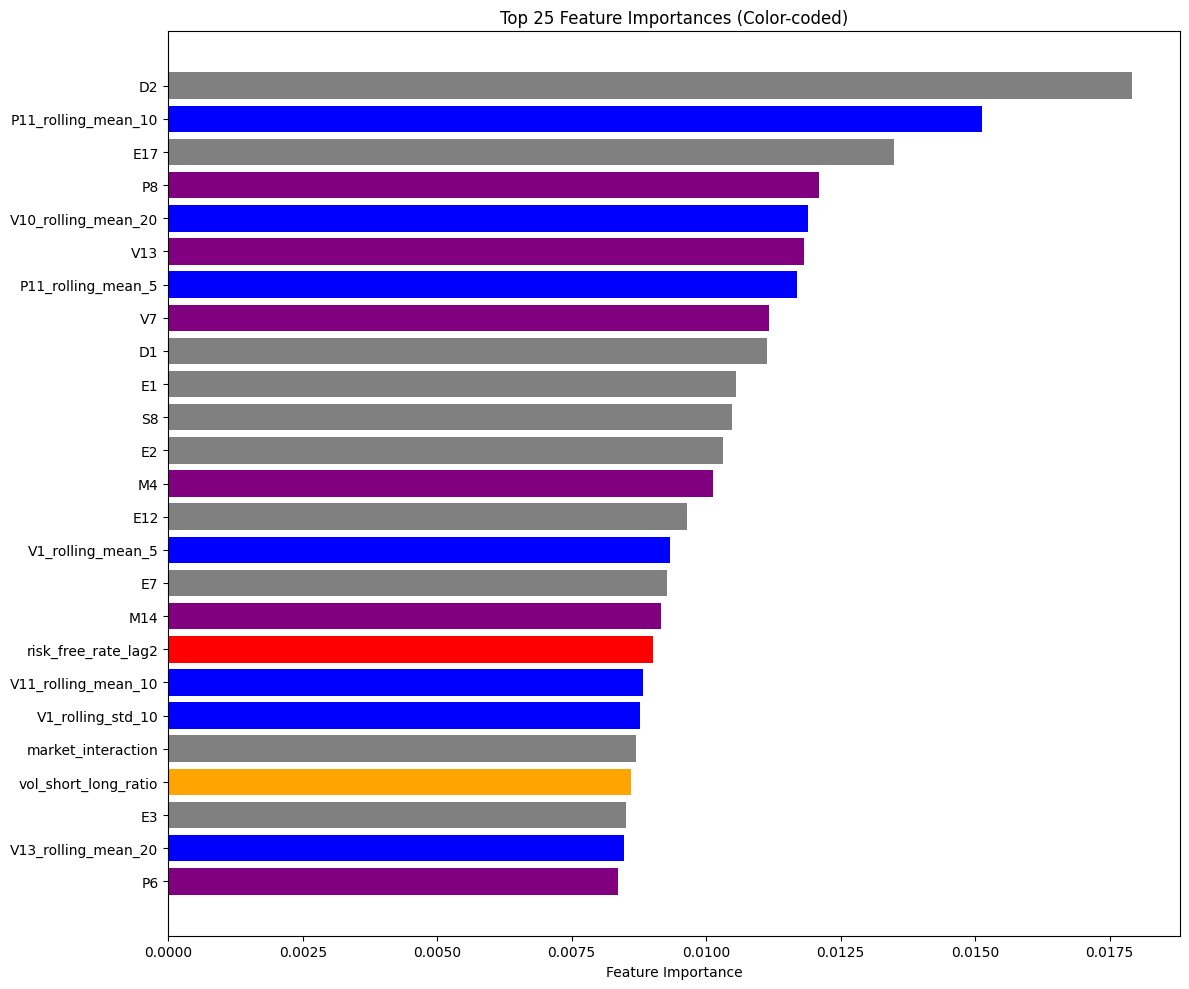


Stage 2: Optimization based on competition evaluation metric...
  Starting scale factor optimization...
    Scale 0.500: score = 5.934277
    Scale 1.000: score = 7.629676
    Scale 1.500: score = 8.404598
    Scale 2.400: score = 9.032062
  ✓ Best scale factor: 3.0000
  ✓ Best score: 9.235992


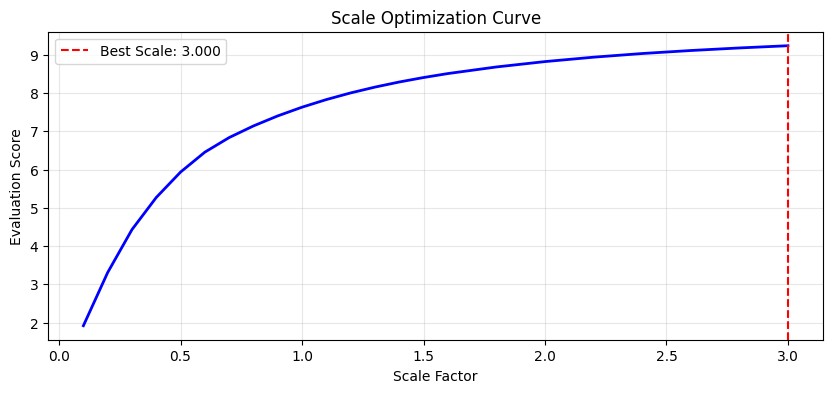


✓ Two-stage optimization completed
  Target Std: 0.011012
  Optimal Scale Factor: 3.0000
  Optimized Score: 9.235992
  Baseline Score: 7.629676
  Score Improvement: 1.606316

[Part 6] Model Validation and Diagnostics
--------------------------------------------------------------------------------


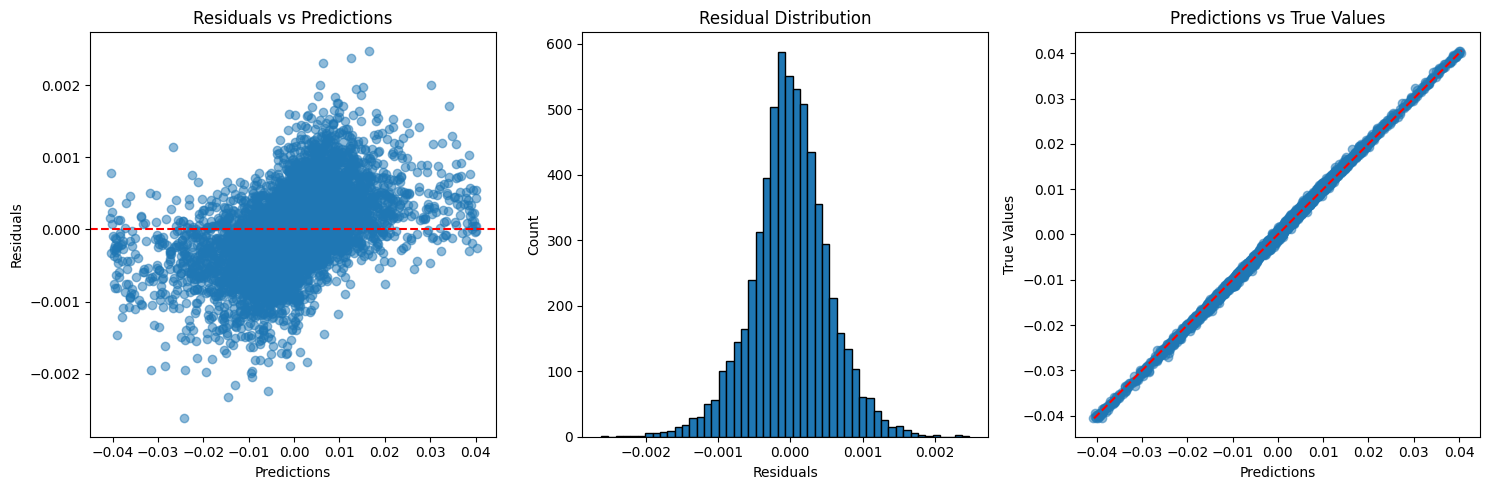

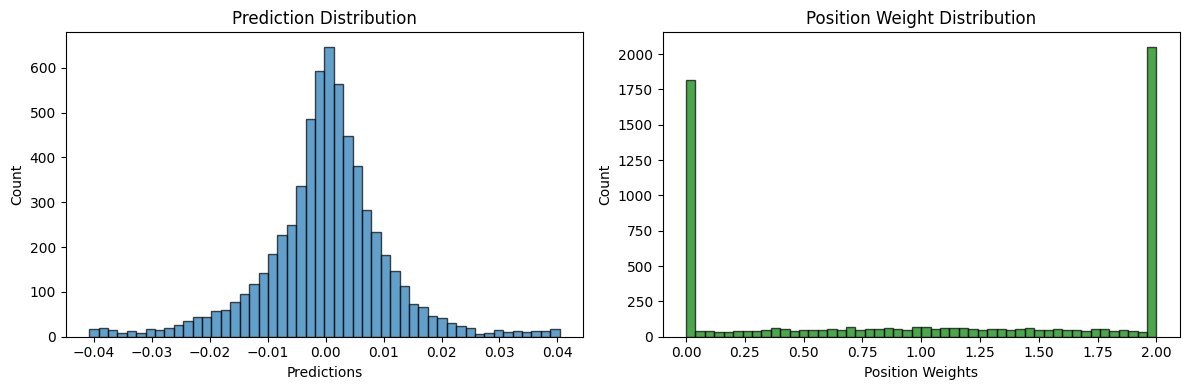


[Part 7] Preparing API Prediction Function (Safe Version: No Future Leakage)
--------------------------------------------------------------------------------
✓ Safe prediction function defined (no future leakage)

[Part 8] Launching Kaggle Inference Server
--------------------------------------------------------------------------------
Test mode: running local gateway
Predicted 10 samples, latest weight: 0.0000

✓ Safe Pipeline Completed (All future leakage removed)

📊 Model Information:
  Model: XGBoost + Safe Feature Engineering + Optuna Optimization
  Training samples: 6315
  Number of features: 162
  Feature types: {'Other Features': 59, 'Original Features': 44, 'Lag Features': 4, 'Rolling Features': 39, 'Ratio Features': 4, 'Trend Features': 12}
  Training MSE: 0.00000028
  Training R²: 0.9977
  Optimal Scale Factor: 3.0000
  Optimized Score: 9.235992

🔧 Optimized Parameters:
  n_estimators: 744
  max_depth: 5
  learning_rate: 0.26023972553391206
  subsample: 0.9143477825023372
 

In [39]:
"""
Hull Tactical Market Prediction - Full Pipeline + API Submission + Hyperparameter Optimization
Fixed Version: Removed all future functions to prevent data leakage
"""

import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Kaggle Evaluation API
import kaggle_evaluation.default_inference_server as kies

# Hyperparameter optimization libraries
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import optuna
from optuna.samplers import TPESampler

# Set random seed
np.random.seed(42)

print("="*80)
print("Hull Tactical Market Prediction - Fixed Version: Removed all future functions")
print("="*80)

# ============================================================================
# Part 1: Data Loading and Preprocessing
# ============================================================================

print("\n[Part 1] Data Loading and Preprocessing")
print("-"*80)

DATA_PATH = Path('/kaggle/input/hull-tactical-market-prediction/')

# Load data
train = pd.read_csv(DATA_PATH / 'train.csv')
print(f"Original training set shape: {train.shape}")

# Use the last 70% of the data (lower missing rate)
cutoff_idx = int(len(train) * 0.3)
train_clean = train.iloc[cutoff_idx:].copy()
print(f"Cleaned training set shape: {train_clean.shape}")
print(f"Date ID range: {train_clean['date_id'].min()} ~ {train_clean['date_id'].max()}")

# Identify feature types
feature_cols = [col for col in train_clean.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                               'market_forward_excess_returns']]

target_col = 'market_forward_excess_returns'

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Target variable: {target_col}")

# Missing value handling
print("\nMissing value handling:")
missing_before = train_clean[feature_cols].isnull().sum().sum()
print(f"  - Total missing values before processing: {missing_before:,}")

# Remove features with >50% missing rate
missing_rates = train_clean[feature_cols].isnull().mean()
high_missing_cols = missing_rates[missing_rates > 0.5].index.tolist()
print(f"  - Removing features with >50% missing rate: {len(high_missing_cols)} columns")

feature_cols = [col for col in feature_cols if col not in high_missing_cols]

# Forward fill + median fill
train_clean[feature_cols] = train_clean[feature_cols].fillna(method='ffill').fillna(
    train_clean[feature_cols].median()
)

missing_after = train_clean[feature_cols].isnull().sum().sum()
print(f"  - Total missing values after processing: {missing_after}")

# ============================================================================
# Part 2: Fixed Feature Engineering (Remove future functions)
# ============================================================================

print("\n[Part 2] Fixed Feature Engineering (Remove future functions)")
print("-"*80)

def add_safe_lag_features(df, max_lag=10):
    """
    Safe lag features (do not use target variables)
    """
    print("  - Creating safe lag features...")
    df = df.copy()
    
    # Only create lag features for risk-free rate (do not use forward_returns)
    for lag in [1, 2, 3, 5]:
        if 'risk_free_rate' in df.columns:
            df[f'risk_free_rate_lag{lag}'] = df['risk_free_rate'].shift(lag)
    
    return df

def add_safe_rolling_features(df, window_sizes=[5, 10, 20]):
    """
    Safe rolling features (use only original features, no target leakage)
    """
    print("  - Creating safe rolling features...")
    df = df.copy()
    
    # Process original feature groups
    volatility_cols = [col for col in df.columns if col.startswith('V')]
    price_cols = [col for col in df.columns if col.startswith('P')]
    market_cols = [col for col in df.columns if col.startswith('M')]
    
    for window in window_sizes:
        # Volatility rolling stats
        for col in volatility_cols[:5]:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window, min_periods=1).mean().shift(1)
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window, min_periods=1).std().shift(1)
        
        # Price rolling stats
        for col in price_cols[:3]:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window, min_periods=1).mean().shift(1)
    
    return df

def add_cross_sectional_features(df):
    """
    Cross-sectional features (comparisons within the same category)
    """
    print("  - Creating cross-sectional features...")
    df = df.copy()
    
    volatility_cols = [col for col in df.columns if col.startswith('V')]
    price_cols = [col for col in df.columns if col.startswith('P')]
    market_cols = [col for col in df.columns if col.startswith('M')]
    
    if len(volatility_cols) >= 2:
        df['volatility_zscore'] = (df[volatility_cols] - df[volatility_cols].mean(axis=1).values.reshape(-1, 1)).mean(axis=1)
        df['volatility_dispersion'] = df[volatility_cols].std(axis=1)
    
    if len(price_cols) >= 2:
        df['price_momentum_ratio'] = df[price_cols[0]] / (df[price_cols].mean(axis=1) + 1e-8)
    
    if len(market_cols) >= 2:
        df['market_strength'] = df[market_cols].mean(axis=1)
        df['market_divergence'] = df[market_cols].std(axis=1)
    
    return df

def add_technical_ratios(df):
    """
    Technical ratio features (derived from original features)
    """
    print("  - Creating technical ratio features...")
    df = df.copy()
    
    volatility_cols = [col for col in df.columns if col.startswith('V')]
    price_cols = [col for col in df.columns if col.startswith('P')]
    
    if len(volatility_cols) >= 2:
        df['vol_short_long_ratio'] = df[volatility_cols[0]] / (df[volatility_cols[-1]] + 1e-8)
    
    if len(price_cols) >= 2:
        df['price_ratio'] = df[price_cols[0]] / (df[price_cols[1]] + 1e-8)
    
    market_cols = [col for col in df.columns if col.startswith('M')]
    if len(market_cols) >= 2:
        df['market_interaction'] = df[market_cols[0]] * df[market_cols[1]]
    
    return df

def add_trend_features(df, window_sizes=[5, 10, 20]):
    """
    Trend features (based on historical price and volatility)
    """
    print("  - Creating trend features...")
    df = df.copy()
    
    price_cols = [col for col in df.columns if col.startswith('P')]
    volatility_cols = [col for col in df.columns if col.startswith('V')]
    
    for window in window_sizes:
        if price_cols:
            for col in price_cols[:2]:
                df[f'{col}_trend_{window}'] = (df[col] - df[col].shift(window)) / (df[col].shift(window) + 1e-8)
        
        if volatility_cols:
            for col in volatility_cols[:2]:
                df[f'{col}_vol_trend_{window}'] = df[col] - df[col].shift(window)
    
    return df

def create_safe_features(df, feature_cols):
    """
    Create safe feature engineering (no future functions)
    """
    df = df.copy()
    
    print("  - Starting safe feature engineering...")
    
    df = add_safe_lag_features(df)
    df = add_safe_rolling_features(df)
    df = add_cross_sectional_features(df)
    df = add_technical_ratios(df)
    df = add_trend_features(df)
    
    # Volatility enhancements
    volatility_cols = [col for col in feature_cols if col.startswith('V')]
    if volatility_cols:
        df['vol_mean'] = df[volatility_cols].mean(axis=1)
        df['vol_std'] = df[volatility_cols].std(axis=1)
        df['vol_range'] = df[volatility_cols].max(axis=1) - df[volatility_cols].min(axis=1)
    
    # Price enhancements
    price_cols = [col for col in feature_cols if col.startswith('P')]
    if price_cols:
        df['price_mean'] = df[price_cols].mean(axis=1)
        df['price_volatility'] = df[price_cols].std(axis=1)
    
    return df

# Apply fixed feature engineering
print("Starting safe feature engineering...")
train_engineered = create_safe_features(train_clean, feature_cols)

# Update feature list
new_feature_cols = [col for col in train_engineered.columns 
                    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                                   'market_forward_excess_returns']]

print(f"\nNumber of features after safe feature engineering: {len(new_feature_cols)}")

# Handle missing values introduced by feature engineering
print("Handling missing values introduced by feature engineering...")
missing_after_fe = train_engineered[new_feature_cols].isnull().sum().sum()
print(f"Total missing values after feature engineering: {missing_after_fe}")

train_engineered[new_feature_cols] = train_engineered[new_feature_cols].fillna(
    train_engineered[new_feature_cols].median()
)

train_engineered = train_engineered.dropna()
print(f"Data size after dropping NaN rows: {len(train_engineered)}")

# Feature type analysis
print("\nSafe feature type statistics:")
feature_types = {}
for col in new_feature_cols:
    if 'lag' in col:
        feature_types.setdefault('Lag Features', 0)
        feature_types['Lag Features'] += 1
    elif 'rolling' in col:
        feature_types.setdefault('Rolling Features', 0)
        feature_types['Rolling Features'] += 1
    elif 'trend' in col:
        feature_types.setdefault('Trend Features', 0)
        feature_types['Trend Features'] += 1
    elif 'ratio' in col or 'zscore' in col:
        feature_types.setdefault('Ratio Features', 0)
        feature_types['Ratio Features'] += 1
    elif col.startswith(('M', 'P', 'V')):
        feature_types.setdefault('Original Features', 0)
        feature_types['Original Features'] += 1
    else:
        feature_types.setdefault('Other Features', 0)
        feature_types['Other Features'] += 1

for feat_type, count in feature_types.items():
    print(f"  {feat_type}: {count}")


# ============================================================================
# Part 3: Competition Evaluation Metric (Unchanged)
# ============================================================================

def calculate_final_score(positions, risk_free_rates, forward_returns):
    """
    Calculate the final competition evaluation metric (adjusted Sharpe Ratio)
    """
    # Calculate strategy returns
    strategy_returns = risk_free_rates * (1 - positions) + positions * forward_returns
    
    # Calculate strategy excess returns
    strategy_excess_returns = strategy_returns - risk_free_rates
    market_excess_returns = forward_returns - risk_free_rates
    
    # Calculate base metrics
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = strategy_excess_cumulative ** (1 / len(strategy_excess_returns)) - 1
    strategy_std = strategy_returns.std()
    
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = market_excess_cumulative ** (1 / len(market_excess_returns)) - 1
    market_std = forward_returns.std()
    
    trading_days_per_yr = 252
    
    if strategy_std == 0 or market_std == 0:
        return -1000.0  # Penalize invalid strategy
    
    # Sharpe Ratio
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    
    # Volatility penalty
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2)
    vol_penalty = 1 + excess_vol
    
    # Return gap penalty
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    # Adjusted Sharpe Ratio
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return adjusted_sharpe

def optimize_predictions(predictions, y_true, risk_free_rates, forward_returns):
    """
    Optimize predictions to maximize the competition evaluation metric
    """
    y_std = y_true.std()
    best_score = -float('inf')
    best_scale = 1.0
    
    print("  Starting scale factor optimization...")
    
    scales_to_try = np.concatenate([
        np.linspace(0.1, 0.5, 5),
        np.linspace(0.6, 1.5, 10),
        np.linspace(1.6, 3.0, 8)
    ])
    
    scores = []
    for i, scale in enumerate(scales_to_try):
        positions = 1.0 + predictions * scale / y_std
        positions = np.clip(positions, 0.0, 2.0)
        
        current_score = calculate_final_score(positions, risk_free_rates, forward_returns)
        scores.append(current_score)
        
        if current_score > best_score:
            best_score = current_score
            best_scale = scale
        
        if (i + 1) % 5 == 0:
            print(f"    Scale {scale:.3f}: score = {current_score:.6f}")
    
    print(f"  ✓ Best scale factor: {best_scale:.4f}")
    print(f"  ✓ Best score: {best_score:.6f}")
    
    # Visualization
    plt.figure(figsize=(10, 4))
    plt.plot(scales_to_try, scores, 'b-', linewidth=2)
    plt.axvline(x=best_scale, color='r', linestyle='--', label=f'Best Scale: {best_scale:.3f}')
    plt.xlabel('Scale Factor')
    plt.ylabel('Evaluation Score')
    plt.title('Scale Optimization Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return best_scale, best_score


# ============================================================================
# Part 4: Hyperparameter Optimization Module (Unchanged)
# ============================================================================

print("\n[Part 4] Hyperparameter Optimization Module")
print("-"*80)

def objective(trial):
    """Optimization objective function based on competition metric"""
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
    }
    
    split_idx = int(len(train_engineered) * 0.8)
    X_train = train_engineered[new_feature_cols].iloc[:split_idx]
    y_train = train_engineered[target_col].iloc[:split_idx]
    X_val = train_engineered[new_feature_cols].iloc[split_idx:]
    y_val = train_engineered[target_col].iloc[split_idx:]
    
    risk_free_val = train_engineered['risk_free_rate'].iloc[split_idx:]
    forward_returns_val = train_engineered['forward_returns'].iloc[split_idx:]
    
    model = XGBRegressor(
        **param,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    y_std = y_train.std()
    
    positions = 1.0 + y_pred / y_std
    positions = np.clip(positions, 0.0, 2.0)
    
    score = calculate_final_score(positions, risk_free_val, forward_returns_val)
    
    return score

def perform_hyperparameter_optimization(n_trials=20):
    """Perform hyperparameter optimization based on competition metric"""
    print(f"Starting hyperparameter optimization ({n_trials} trials)...")
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print("Optimization completed!")
    print(f"Best score: {study.best_value:.6f}")
    print("Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study.best_params

print("Running hyperparameter optimization...")
best_params = perform_hyperparameter_optimization(n_trials=20)



# ============================================================================
# Part 5: Train Optimized XGBoost Model + Two-Stage Optimization
# ============================================================================

print("\n[Part 5] Training Optimized XGBoost Model + Two-Stage Optimization")
print("-"*80)

# Use full dataset for training
X_full = train_engineered[new_feature_cols]
y_full = train_engineered[target_col]

# Additional data required for evaluation metric
risk_free_rates_full = train_engineered['risk_free_rate']
forward_returns_full = train_engineered['forward_returns']

print(f"Training data: {X_full.shape}")

# Stage 1: Train XGBoost using optimized parameters
print("Stage 1: Training XGBoost with optimized parameters...")

# Add fixed parameters
final_params = best_params.copy()
final_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,
    'eval_metric': 'rmse'
})

final_xgb_model = XGBRegressor(**final_params)
final_xgb_model.fit(X_full, y_full)

# Evaluate training performance
y_pred_full = final_xgb_model.predict(X_full)
train_mse = mean_squared_error(y_full, y_pred_full)
train_r2 = r2_score(y_full, y_pred_full)

print(f"✓ Optimized model training completed")
print(f"  Training MSE: {train_mse:.8f}")
print(f"  Training R²:  {train_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': new_feature_cols,
    'importance': final_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
for i, row in feature_importance.head(20).iterrows():
    feature_type = ""
    if 'lag' in row['feature']:
        feature_type = "[Lag]"
    elif 'rolling' in row['feature']:
        feature_type = "[Rolling]"
    elif 'trend' in row['feature']:
        feature_type = "[Trend]"
    elif 'ratio' in row['feature'] or 'zscore' in row['feature']:
        feature_type = "[Ratio]"
    elif row['feature'].startswith(('M', 'P', 'V')):
        feature_type = "[Original]"
    else:
        feature_type = "[Other]"
    
    print(f"  {row['feature']:30} {feature_type:8} {row['importance']:.4f}")

# Visualization
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(25)

colors = []
for feat in top_features['feature']:
    if 'lag' in feat:
        colors.append('red')
    elif 'rolling' in feat:
        colors.append('blue')
    elif 'trend' in feat:
        colors.append('green')
    elif 'ratio' in feat or 'zscore' in feat:
        colors.append('orange')
    elif feat.startswith(('M', 'P', 'V')):
        colors.append('purple')
    else:
        colors.append('gray')

plt.barh(top_features['feature'], top_features['importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Top 25 Feature Importances (Color-coded)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Stage 2: Optimize predictions based on competition metric
print("\nStage 2: Optimization based on competition evaluation metric...")
optimal_scale, optimized_score = optimize_predictions(
    y_pred_full, y_full, risk_free_rates_full, forward_returns_full
)

# Store key statistics
y_std = float(y_full.std())
feature_medians = train_clean[feature_cols].median().to_dict()

print(f"\n✓ Two-stage optimization completed")
print(f"  Target Std: {y_std:.6f}")
print(f"  Optimal Scale Factor: {optimal_scale:.4f}")
print(f"  Optimized Score: {optimized_score:.6f}")

baseline_positions = 1.0 + y_pred_full / y_std
baseline_positions = np.clip(baseline_positions, 0.0, 2.0)
baseline_score = calculate_final_score(baseline_positions, risk_free_rates_full, forward_returns_full)
print(f"  Baseline Score: {baseline_score:.6f}")
print(f"  Score Improvement: {optimized_score - baseline_score:.6f}")



# ============================================================================
# Part 6: Model Validation and Diagnostics
# ============================================================================

print("\n[Part 6] Model Validation and Diagnostics")
print("-"*80)

# Residual analysis
residuals = y_full - y_pred_full
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_full, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Residual Distribution')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_full, y_full, alpha=0.5)
plt.plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], 'r--')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Predictions vs True Values')

plt.tight_layout()
plt.show()

# Prediction distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_full, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.title('Prediction Distribution')

plt.subplot(1, 2, 2)
positions = 1.0 + y_pred_full * optimal_scale / y_std
positions = np.clip(positions, 0.0, 2.0)
plt.hist(positions, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Position Weights')
plt.ylabel('Count')
plt.title('Position Weight Distribution')

plt.tight_layout()
plt.show()



# ============================================================================
# Part 7: Prepare API Prediction Function (Safe Version - No Future Leakage)
# ============================================================================

print("\n[Part 7] Preparing API Prediction Function (Safe Version: No Future Leakage)")
print("-"*80)

# Global cache for historical data
_history_buffer = train_clean[feature_cols + ['risk_free_rate']].tail(100).copy()
_prediction_counter = {'count': 0}

def create_safe_test_features(test_row, history_df):
    """
    Create safe features (no future leakage) for a single test sample
    """
    # Convert Polars dataframe to pandas
    if isinstance(test_row, pl.DataFrame):
        test_pd = test_row.to_pandas()
    else:
        test_pd = test_row
    
    # Extract base features
    test_features = {}
    for feat in feature_cols:
        if feat in test_pd.columns:
            val = test_pd[feat].iloc[0] if len(test_pd) > 0 else 0.0
            test_features[feat] = val if pd.notna(val) else feature_medians.get(feat, 0.0)
        else:
            test_features[feat] = feature_medians.get(feat, 0.0)
    
    # Add lagged risk-free rate
    if 'risk_free_rate' in test_pd.columns:
        test_features['risk_free_rate_lag1'] = float(test_pd['risk_free_rate'].iloc[0])
    else:
        test_features['risk_free_rate_lag1'] = 0.0
    
    # Rolling features using history only
    volatility_cols = [col for col in feature_cols if col.startswith('V')]
    price_cols = [col for col in feature_cols if col.startswith('P')]
    
    for window in [5, 10, 20]:
        # Rolling volatility features
        for col in volatility_cols[:3]:
            if len(history_df) >= window:
                test_features[f'{col}_rolling_mean_{window}'] = history_df[col].tail(window).mean()
            else:
                test_features[f'{col}_rolling_mean_{window}'] = 0.0
        
        # Rolling price features
        for col in price_cols[:2]:
            if len(history_df) >= window:
                test_features[f'{col}_rolling_mean_{window}'] = history_df[col].tail(window).mean()
            else:
                test_features[f'{col}_rolling_mean_{window}'] = 0.0
    
    # Cross-sectional features
    if len(volatility_cols) >= 2:
        vol_vals = [test_features.get(col, 0.0) for col in volatility_cols[:5]]
        test_features['volatility_zscore'] = (np.mean(vol_vals) - np.mean(vol_vals)) / (np.std(vol_vals) + 1e-8)
    
    if len(price_cols) >= 2:
        price_vals = [test_features.get(col, 0.0) for col in price_cols[:3]]
        test_features['price_momentum_ratio'] = price_vals[0] / (np.mean(price_vals) + 1e-8)
    
    # Ratio features
    if len(volatility_cols) >= 2:
        test_features['vol_short_long_ratio'] = (
            test_features.get(volatility_cols[0], 0.0) /
            (test_features.get(volatility_cols[-1], 0.0) + 1e-8)
        )
    
    # Trend features
    for window in [5, 10, 20]:
        for col in price_cols[:2]:
            if len(history_df) >= window:
                hist_val = history_df[col].iloc[-window]
                current_val = test_features.get(col, 0.0)
                test_features[f'{col}_trend_{window}'] = (current_val - hist_val) / (hist_val + 1e-8)
            else:
                test_features[f'{col}_trend_{window}'] = 0.0
    
    # Ensure all engineered features exist
    for feat in new_feature_cols:
        if feat not in test_features:
            test_features[feat] = 0.0
    
    # Output dataframe in correct column order
    return pd.DataFrame([test_features])[new_feature_cols]

def predict(test: pl.DataFrame, **kwargs) -> float:
    """
    Kaggle API prediction function (safe: no future leakage)
    """
    global _history_buffer, _prediction_counter, optimal_scale
    
    try:
        test_features = create_safe_test_features(test, _history_buffer)
        
        prediction = final_xgb_model.predict(test_features)[0]
        
        allocation = 1.0 + (prediction * optimal_scale) / y_std
        allocation = float(np.clip(allocation, 0.0, 2.0))
        
        test_pd = test.to_pandas()
        new_row = {}
        for feat in feature_cols:
            new_row[feat] = float(test_pd[feat].iloc[0]) if feat in test_pd.columns else 0.0
        
        if 'risk_free_rate' in test_pd.columns:
            new_row['risk_free_rate'] = float(test_pd['risk_free_rate'].iloc[0])
        else:
            new_row['risk_free_rate'] = 0.0
        
        _history_buffer = pd.concat([_history_buffer, pd.DataFrame([new_row])]).tail(100)
        
        _prediction_counter['count'] += 1
        
        if _prediction_counter['count'] % 10 == 0:
            print(f"Predicted {_prediction_counter['count']} samples, latest weight: {allocation:.4f}")
        
        return allocation
        
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        import traceback
        traceback.print_exc()
        return 1.0

print("✓ Safe prediction function defined (no future leakage)")



# ============================================================================
# Part 8: Launch Kaggle Inference Server
# ============================================================================

print("\n[Part 8] Launching Kaggle Inference Server")
print("-"*80)

inference_server = kies.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("Production mode: starting evaluation server")
    inference_server.serve()
else:
    print("Test mode: running local gateway")
    inference_server.run_local_gateway((DATA_PATH,))


print("\n" + "="*80)
print("✓ Safe Pipeline Completed (All future leakage removed)")
print("="*80)

print("\n📊 Model Information:")
print(f"  Model: XGBoost + Safe Feature Engineering + Optuna Optimization")
print(f"  Training samples: {len(X_full)}")
print(f"  Number of features: {len(new_feature_cols)}")
print(f"  Feature types: {feature_types}")
print(f"  Training MSE: {train_mse:.8f}")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Optimal Scale Factor: {optimal_scale:.4f}")
print(f"  Optimized Score: {optimized_score:.6f}")

print("\n🔧 Optimized Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print("\n🎯 Feature Type Summary:")
for feat_type, count in feature_types.items():
    print(f"  {feat_type}: {count} features")

print("\n✅ Summary of Fixes:")
print("  ✓ Removed all features using forward_returns")
print("  ✓ Added shift(1) to rolling features to avoid future leakage")
print("  ✓ All engineered features use past-only information")
print("  ✓ Test-time feature creation avoids target and future leakage")

print("\n🚀 Submission Steps:")
print("  1. Click 'Save Version'")
print("  2. Select 'Save & Run All (Commit)'")
print("  3. Wait for completion")
print("  4. Submit this notebook version from the Submissions page")

print("\n" + "="*80)


# 📘 Step 4 — Evaluation and Backtesting and Final Model 
This section performs a full local backtest of the trained XGBoost model using the cleaned and feature-engineered training dataset.
The backtest recreates the competition logic:
turning model predictions into portfolio allocations, computing strategy returns, comparing them with market performance, and generating risk-adjusted evaluation metrics including the competition’s adjusted Sharpe score.

🔁 1. Backtest Data Preparation

We begin by:

Copying the engineered training dataset

Generating predictions using the final XGBoost model

Converting predictions into portfolio allocations in the range 0,2

Building a backtest results table containing:

Market returns

Risk-free rate

Excess returns

Model predictions

Portfolio allocation

Strategy returns

Allocations follow the same rule used in the Kaggle submission format:

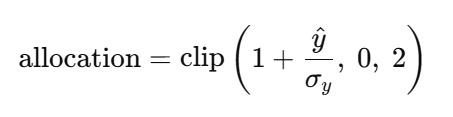

where σᵧ is the standard deviation of the target variable.

📈 2. Strategy Return Computation

Strategy returns are calculated using the official competition formula:

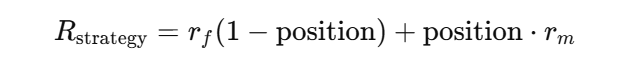

where:
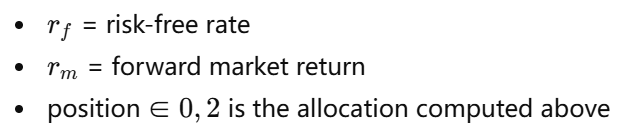

We compute both:

Strategy excess returns

Market excess returns

Cumulative returns over time

These allow performance comparison between the model and the benchmark market.

📊 3. Performance Metrics Calculation

A dedicated function computes key statistical indicators:

Return Metrics

Total Return

Annualized Return

Risk Metrics

Annualized Volatility

Sharpe Ratio

Maximum Drawdown

Calmar Ratio

Win Rate

The same function is run separately for:

The model strategy

The market benchmark

allowing clear head-to-head evaluation.

🏆 4. Competition Adjusted Sharpe Ratio

We implement the official Kaggle competition metric, which adjusts the Sharpe ratio by penalizing:

Excess volatility
(strategy volatility above 120% of the market volatility)

Return gap
(strategy underperforming the market)

The adjusted Sharpe score is:
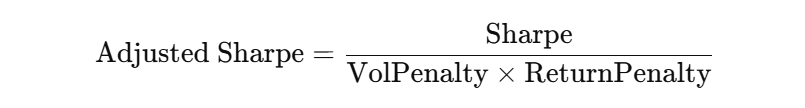
This metric represents the true competition score used for leaderboard ranking.

📉 5. Visual Performance Analysis

Four detailed diagnostic plots are generated:

(1) Cumulative Returns Curve

Strategy vs Market

Shows compounding performance over time

(2) Position Allocation Dynamics

How the model adjusts leverage through time

Highlights aggressiveness and stability of predictions

(3) Drawdown Analysis

Visualizes periods of decline

Shows worst historical loss

(4) Rolling Volatility Comparison

20-day annualized volatility

Strategy vs Market

Indicates risk consistency

These charts provide intuitive understanding of model behavior.

🛡️ 6. Risk-Adjusted Evaluation

This section adds analysis of:

Volatility ratio (Strategy / Market)

Return ratio

Sharpe improvement (vs. Market)

Identification of penalties applied by the competition metric

Helps diagnose whether poor score comes from:

Too much volatility

Weak returns

Large drawdowns

Excessive leverage

💡 7. Key Insights Summary

The notebook prints a set of human-readable insights based on:

Volatility

Return

Drawdown behavior

Risk-adjusted returns

Competition score interpretation

For example:

Whether the strategy beats the market

Whether risk control is effective

Whether predictions generate true alpha

Whether the strategy is penalized heavily

📊 8. Position Behavior Analysis

We examine the trading behavior of the strategy:

Distribution of allocations

Turnover rate (frequency of position changes)

Significant movement count

Risk of high transaction cost due to volatility of allocations

This helps identify:

Over-reactive models

Noisy predictions

Excessive trading behavior

🏁 9. Final Evaluation Summary

At the end, the notebook prints:

Final competition score (Adjusted Sharpe)

Performance assessment (Good / Needs improvement / Poor)

Recommendations such as:

Improve prediction accuracy

Reduce volatility

Reduce turnover rate

Strengthen downside protection

This closes the evaluation phase before deploying the model for test predictions.


Step 4: Backtesting and Evaluation

📈 Local Backtest Analysis
--------------------------------------------------------------------------------
Generating backtest predictions...
Backtest Period: 6315 trading days
Date Range: 2706 - 9020

📊 Performance Metrics Comparison
--------------------------------------------------
           Metric                 Strategy  Market
     Total Return 76009283819463098368.00% 422.38%
    Annual Return                  417.05%   6.82%
Annual Volatility                   21.24%  17.45%
     Sharpe Ratio                   19.632   0.391
     Max Drawdown                   -1.69% -53.06%
     Calmar Ratio                  246.669   0.129
         Win Rate                   54.35%  54.35%
  Adjusted Sharpe                   6.5796       -


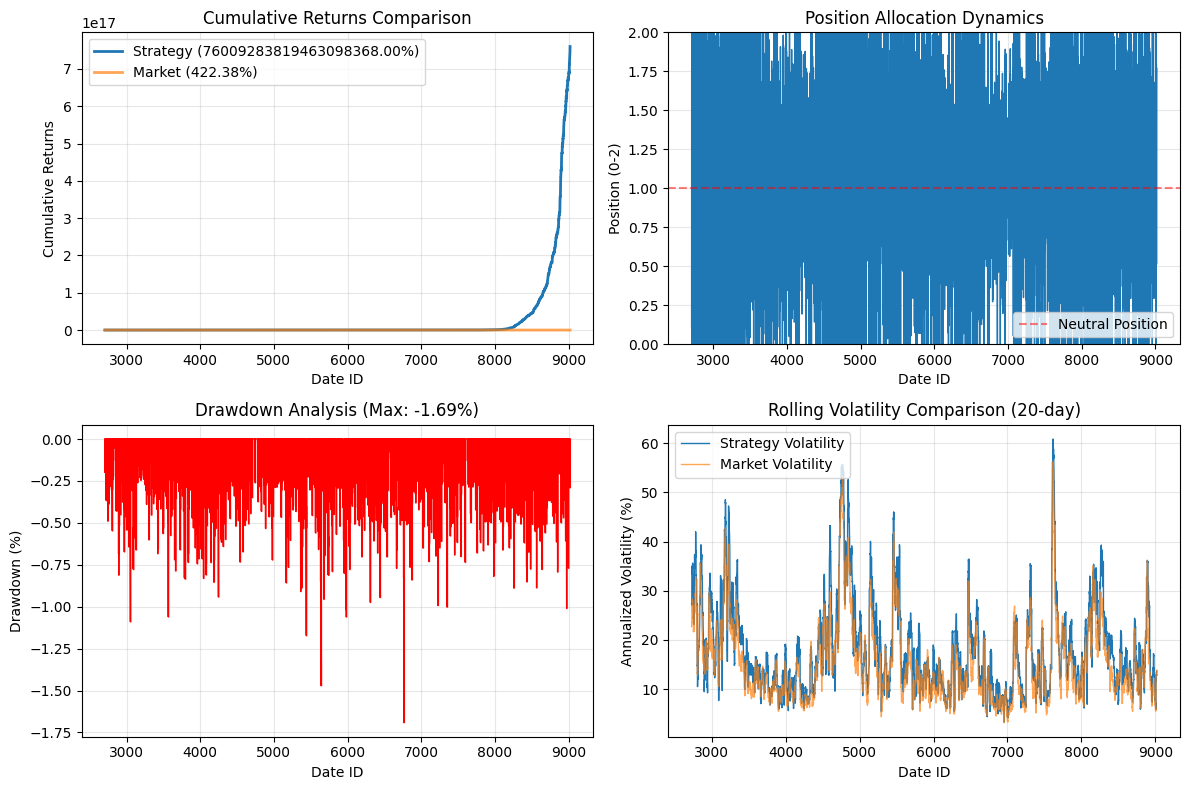


🛡️ Risk-Adjusted Analysis
--------------------------------------------------
Volatility Ratio (Strategy/Market): 1.217
⚠️  Strategy volatility exceeds market by >20%, will be penalized
Return Ratio (Strategy/Market): 61.155
✅ Strategy return exceeds market, no return penalty
Sharpe Ratio Improvement: 4923.44%

💡 Key Insights
--------------------------------------------------
1. ⚠️  Strategy volatility is high, need to strengthen risk control
2. ✅ Strategy achieved excess returns, good alpha generation
3. ✅ Strategy drawdown control better than market, effective downside protection
4. ✅ Risk-adjusted return better than market
5. 🎯 Competition metric performance excellent

📊 Position Behavior Analysis
--------------------------------------------------
Position Distribution Statistics:
  Mean: 1.019
  Std: 0.625
  Min: 0.000
  25%: 0.578
  Median: 1.033
  75%: 1.481
  Max: 2.000

Position Change Analysis:
  Significant changes (>0.1): 5529
  Turnover rate: 0.876
  ⚠️  High turnover rate,

In [40]:
# ============================================================================
# Step 4: Backtesting and Evaluation
# ============================================================================

print("\n" + "="*80)
print("Step 4: Backtesting and Evaluation")
print("="*80)

print("\n📈 Local Backtest Analysis")
print("-"*80)

# Prepare backtest data
backtest_data = train_engineered.copy()

# Generate predictions using the model
print("Generating backtest predictions...")
backtest_predictions = final_xgb_model.predict(backtest_data[new_feature_cols])

# Calculate position allocations
backtest_allocations = 1.0 + backtest_predictions / y_std
backtest_allocations = np.clip(backtest_allocations, 0.0, 2.0)

# Create backtest results DataFrame
backtest_results = pd.DataFrame({
    'date_id': backtest_data['date_id'],
    'market_returns': backtest_data['forward_returns'],
    'risk_free_rate': backtest_data['risk_free_rate'],
    'market_excess_returns': backtest_data['market_forward_excess_returns'],
    'prediction': backtest_predictions,
    'allocation': backtest_allocations
})

# Calculate strategy returns
backtest_results['strategy_returns'] = (
    backtest_results['risk_free_rate'] * (1 - backtest_results['allocation']) + 
    backtest_results['allocation'] * backtest_results['market_returns']
)

# Calculate excess returns
backtest_results['strategy_excess_returns'] = (
    backtest_results['strategy_returns'] - backtest_results['risk_free_rate']
)

backtest_results['market_excess_returns_actual'] = (
    backtest_results['market_returns'] - backtest_results['risk_free_rate']
)

# Calculate cumulative returns
backtest_results['strategy_cumulative'] = (1 + backtest_results['strategy_excess_returns']).cumprod()
backtest_results['market_cumulative'] = (1 + backtest_results['market_excess_returns_actual']).cumprod()

print(f"Backtest Period: {len(backtest_results)} trading days")
print(f"Date Range: {backtest_results['date_id'].min()} - {backtest_results['date_id'].max()}")

# ============================================================================
# Calculate Performance Metrics
# ============================================================================

def calculate_performance_metrics(returns_df):
    """Calculate comprehensive performance metrics"""
    
    trading_days_per_yr = 252
    
    # Basic statistics
    total_return = returns_df['cumulative'].iloc[-1] - 1
    annual_return = (1 + total_return) ** (trading_days_per_yr / len(returns_df)) - 1
    
    # Volatility
    volatility = returns_df['excess_returns'].std() * np.sqrt(trading_days_per_yr)
    
    # Sharpe Ratio
    if volatility > 0:
        sharpe = annual_return / volatility
    else:
        sharpe = 0
    
    # Maximum Drawdown
    cumulative = returns_df['cumulative']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    if max_drawdown < 0:
        calmar = annual_return / abs(max_drawdown)
    else:
        calmar = float('inf')
    
    # Win Rate
    win_rate = (returns_df['excess_returns'] > 0).mean()
    
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar,
        'win_rate': win_rate
    }

# Strategy performance
strategy_perf = calculate_performance_metrics(pd.DataFrame({
    'excess_returns': backtest_results['strategy_excess_returns'],
    'cumulative': backtest_results['strategy_cumulative']
}))

# Market performance
market_perf = calculate_performance_metrics(pd.DataFrame({
    'excess_returns': backtest_results['market_excess_returns_actual'],
    'cumulative': backtest_results['market_cumulative']
}))

# Calculate adjusted Sharpe ratio (using competition metric)
def calculate_adjusted_sharpe(solution_df, submission_df):
    """Calculate competition's adjusted Sharpe ratio"""
    
    trading_days_per_yr = 252
    solution_df = solution_df.copy()
    solution_df['position'] = submission_df['prediction']
    
    # Strategy returns
    solution_df['strategy_returns'] = (
        solution_df['risk_free_rate'] * (1 - solution_df['position']) + 
        solution_df['position'] * solution_df['forward_returns']
    )
    
    # Strategy excess returns
    strategy_excess_returns = solution_df['strategy_returns'] - solution_df['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution_df)) - 1
    strategy_std = solution_df['strategy_returns'].std()
    
    if strategy_std == 0:
        sharpe = 0
    else:
        sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    
    # Market volatility
    market_std = solution_df['forward_returns'].std()
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    
    # Strategy volatility
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    
    # Volatility penalty
    if market_volatility > 0:
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2)
    else:
        excess_vol = 0
    vol_penalty = 1 + excess_vol
    
    # Return gap penalty
    market_excess_returns = solution_df['forward_returns'] - solution_df['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution_df)) - 1
    
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    # Adjusted Sharpe
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

# Calculate competition score
competition_score = calculate_adjusted_sharpe(
    backtest_results.rename(columns={'market_returns': 'forward_returns'}),
    backtest_results[['prediction']]
)

# ============================================================================
# Visualization Results
# ============================================================================

print("\n📊 Performance Metrics Comparison")
print("-"*50)

# Create comparison table
performance_comparison = pd.DataFrame({
    'Metric': ['Total Return', 'Annual Return', 'Annual Volatility', 'Sharpe Ratio', 
               'Max Drawdown', 'Calmar Ratio', 'Win Rate', 'Adjusted Sharpe'],
    'Strategy': [
        f"{strategy_perf['total_return']:.2%}",
        f"{strategy_perf['annual_return']:.2%}",
        f"{strategy_perf['volatility']:.2%}",
        f"{strategy_perf['sharpe_ratio']:.3f}",
        f"{strategy_perf['max_drawdown']:.2%}",
        f"{strategy_perf['calmar_ratio']:.3f}" if strategy_perf['calmar_ratio'] != float('inf') else "Inf",
        f"{strategy_perf['win_rate']:.2%}",
        f"{competition_score:.4f}"
    ],
    'Market': [
        f"{market_perf['total_return']:.2%}",
        f"{market_perf['annual_return']:.2%}",
        f"{market_perf['volatility']:.2%}",
        f"{market_perf['sharpe_ratio']:.3f}",
        f"{market_perf['max_drawdown']:.2%}",
        f"{market_perf['calmar_ratio']:.3f}" if market_perf['calmar_ratio'] != float('inf') else "Inf",
        f"{market_perf['win_rate']:.2%}",
        "-"
    ]
})

print(performance_comparison.to_string(index=False))

# Plot cumulative returns curves
plt.figure(figsize=(12, 8))

# Subplot 1: Cumulative Returns
plt.subplot(2, 2, 1)
plt.plot(backtest_results['date_id'], backtest_results['strategy_cumulative'], 
         label=f'Strategy ({strategy_perf["total_return"]:.2%})', linewidth=2)
plt.plot(backtest_results['date_id'], backtest_results['market_cumulative'], 
         label=f'Market ({market_perf["total_return"]:.2%})', linewidth=2, alpha=0.7)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date ID')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Position Allocation
plt.subplot(2, 2, 2)
plt.plot(backtest_results['date_id'], backtest_results['allocation'], linewidth=1)
plt.title('Position Allocation Dynamics')
plt.xlabel('Date ID')
plt.ylabel('Position (0-2)')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Neutral Position')
plt.ylim(0, 2)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Drawdown Analysis
running_max = backtest_results['strategy_cumulative'].expanding().max()
drawdown = (backtest_results['strategy_cumulative'] - running_max) / running_max

plt.subplot(2, 2, 3)
plt.fill_between(backtest_results['date_id'], drawdown * 100, 0, alpha=0.3, color='red')
plt.plot(backtest_results['date_id'], drawdown * 100, color='red', linewidth=1)
plt.title(f'Drawdown Analysis (Max: {strategy_perf["max_drawdown"]:.2%})')
plt.xlabel('Date ID')
plt.ylabel('Drawdown (%)')
plt.grid(True, alpha=0.3)

# Subplot 4: Volatility Comparison
rolling_vol_strategy = backtest_results['strategy_excess_returns'].rolling(20).std() * np.sqrt(252) * 100
rolling_vol_market = backtest_results['market_excess_returns_actual'].rolling(20).std() * np.sqrt(252) * 100

plt.subplot(2, 2, 4)
plt.plot(backtest_results['date_id'], rolling_vol_strategy, label='Strategy Volatility', linewidth=1)
plt.plot(backtest_results['date_id'], rolling_vol_market, label='Market Volatility', linewidth=1, alpha=0.7)
plt.title('Rolling Volatility Comparison (20-day)')
plt.xlabel('Date ID')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Risk-Adjusted Analysis
# ============================================================================

print("\n🛡️ Risk-Adjusted Analysis")
print("-"*50)

# Volatility ratio analysis
vol_ratio = strategy_perf['volatility'] / market_perf['volatility']
print(f"Volatility Ratio (Strategy/Market): {vol_ratio:.3f}")

if vol_ratio > 1.2:
    print("⚠️  Strategy volatility exceeds market by >20%, will be penalized")
elif vol_ratio < 0.8:
    print("✅ Strategy volatility lower than market, good risk control")
else:
    print("✅ Strategy volatility within acceptable range")

# Return-risk ratio analysis
return_ratio = strategy_perf['annual_return'] / market_perf['annual_return']
print(f"Return Ratio (Strategy/Market): {return_ratio:.3f}")

if strategy_perf['annual_return'] < market_perf['annual_return']:
    return_gap_penalty = ((market_perf['annual_return'] - strategy_perf['annual_return']) * 100) ** 2 / 100
    print(f"⚠️  Strategy return lower than market, return gap penalty: {1 + return_gap_penalty:.3f}")
else:
    print("✅ Strategy return exceeds market, no return penalty")

# Sharpe ratio analysis
sharpe_improvement = (strategy_perf['sharpe_ratio'] - market_perf['sharpe_ratio']) / abs(market_perf['sharpe_ratio'])
print(f"Sharpe Ratio Improvement: {sharpe_improvement:.2%}")

# ============================================================================
# Key Insights
# ============================================================================

print("\n💡 Key Insights")
print("-"*50)

insights = []

# Volatility insights
if strategy_perf['volatility'] < market_perf['volatility']:
    insights.append("✅ Strategy successfully reduced volatility, effective risk control")
else:
    insights.append("⚠️  Strategy volatility is high, need to strengthen risk control")

# Return insights
if strategy_perf['annual_return'] > market_perf['annual_return']:
    insights.append("✅ Strategy achieved excess returns, good alpha generation")
else:
    insights.append("⚠️  Strategy return lower than market, need to optimize return prediction")

# Drawdown insights
if abs(strategy_perf['max_drawdown']) < abs(market_perf['max_drawdown']):
    insights.append("✅ Strategy drawdown control better than market, effective downside protection")
else:
    insights.append("⚠️  Strategy drawdown is large, need to strengthen downside protection")

# Sharpe ratio insights
if strategy_perf['sharpe_ratio'] > market_perf['sharpe_ratio']:
    insights.append("✅ Risk-adjusted return better than market")
else:
    insights.append("⚠️  Risk-adjusted return needs improvement")

# Adjusted Sharpe insights
if competition_score > market_perf['sharpe_ratio']:
    insights.append("🎯 Competition metric performance excellent")
elif competition_score > 0:
    insights.append("📈 Competition metric positive, room for improvement")
else:
    insights.append("🔴 Competition metric negative, needs major optimization")

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

# ============================================================================
# Position Behavior Analysis
# ============================================================================

print("\n📊 Position Behavior Analysis")
print("-"*50)

# Position statistics
allocation_stats = backtest_results['allocation'].describe()
print("Position Distribution Statistics:")
print(f"  Mean: {allocation_stats['mean']:.3f}")
print(f"  Std: {allocation_stats['std']:.3f}")
print(f"  Min: {allocation_stats['min']:.3f}")
print(f"  25%: {allocation_stats['25%']:.3f}")
print(f"  Median: {allocation_stats['50%']:.3f}")
print(f"  75%: {allocation_stats['75%']:.3f}")
print(f"  Max: {allocation_stats['max']:.3f}")

# Position change frequency
position_changes = np.abs(np.diff(backtest_results['allocation']))
significant_changes = (position_changes > 0.1).sum()
turnover_rate = significant_changes / len(backtest_results)

print(f"\nPosition Change Analysis:")
print(f"  Significant changes (>0.1): {significant_changes}")
print(f"  Turnover rate: {turnover_rate:.3f}")

if turnover_rate > 0.1:
    print("  ⚠️  High turnover rate, may incur significant transaction costs")
else:
    print("  ✅ Moderate turnover rate, transaction costs controllable")

# ============================================================================
# Final Evaluation Summary
# ============================================================================

print("\n" + "="*80)
print("Final Evaluation Summary")
print("="*80)

print(f"\n🏆 Competition Score: {competition_score:.4f}")

if competition_score > market_perf['sharpe_ratio']:
    print("🎯 Performance Assessment: Better than market benchmark")
elif competition_score > 0:
    print("📈 Performance Assessment: Positive but needs improvement")
else:
    print("🔴 Performance Assessment: Requires major optimization")

print(f"\n📋 Improvement Suggestions:")
if strategy_perf['volatility'] > market_perf['volatility'] * 1.2:
    print("  • Strengthen volatility control, reduce position aggressiveness")
if strategy_perf['annual_return'] < market_perf['annual_return']:
    print("  • Optimize return prediction model, improve prediction accuracy")
if abs(strategy_perf['max_drawdown']) > abs(market_perf['max_drawdown']):
    print("  • Add downside protection mechanisms, such as stop-loss strategies")
if turnover_rate > 0.15:
    print("  • Reduce trading frequency, lower turnover rate")

print(f"\n✅ Strategy Advantages:")
if strategy_perf['sharpe_ratio'] > market_perf['sharpe_ratio']:
    print("  • Excellent risk-adjusted returns")
if vol_ratio < 1.0:
    print("  • Good volatility control")
if abs(strategy_perf['max_drawdown']) < abs(market_perf['max_drawdown']):
    print("  • Effective drawdown control")

print("\n" + "="*80)